# Multiple Linear Regression

So far we've covered simple linear regression. As we saw, this algorithm/model is quite limitted in what it can accomplish. We'll now expand this model to make a more versatile model.

## What We'll Accomplish in This Notebook

In this notebook we'll do the following:

- Set up the multiple linear regression statistical model,
- Derive the least squares estimate for the model,
- Discuss modeling of categorical variables with one-hot encoding,
- Introduce interaction terms,
- Show how to model polynomial and other nonlinear terms in a linear regression setting

Remember my note about the math from the last notebook, if you're not a math person don't become panicked if there is math content you don't entirely understand. You can always ask questions during a breakout session or on Slack :).

In [1]:
# import the packages we'll use
## For data handling
import pandas as pd
import numpy as np

# We'll use this later
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# This is new, it will allow us to interact with
# 3d plots in the notebook
from mpl_toolkits.mplot3d import Axes3D


## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

## What Changes Going From Feature to Features?

### The Statistical Model

Assume that our data set has $n$ observations.

Recall that in simple linear regression the statistical model is:
$$
y = \beta_0 + \beta_1 X + \epsilon,
$$
where $X$ is an $n\times 1$ feature vector, $y$ is an $n\times 1$ target vector, and $\epsilon$ is an $n\times 1$ vector of independent $\epsilon_i \sim N(0,\sigma^2)$ for all $i$. 


For multiple linear regression instead of a single feature we have $m$ features. In this setting the model becomes:
$$
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_m X_m + \epsilon ,
$$
where $X_1,X_2,\dots,X_m$ are the $m$ features, and $\epsilon$ is the same as in SLR. If we collect all of the features as a single column along with a column of $1$s in an $n \times m$ feature matrix,
$$
X = \left(\begin{array}{c | c | c | c | c}
    1 & X_1 & X_2 & \dots & X_m
\end{array}\right),
$$
and let $\beta=\left(\beta_0, \beta_1, \beta_2,\dots,\beta_m\right)^T$ then the statistical model for MLR becomes:
$$
y = X\beta + \epsilon.
$$

In the explanatory modeling setting we're still making all of the same assumptions as in SLR, but now $y$ is a linear function of $m$ predictors instead of just $1$. 

### Estimating the Model

When it comes to estimating $\beta$ we can get away with just using `sklearn` or `statsmodels`. However it's useful to know how to calculate the estimate 'by hand'.

#### Minimizing MSE

We again set out to minimize the MSE
$$
MSE = \frac{1}{n} \sum_{i=1}^n \left( y_i - \hat{y_i} \right)^2 = \frac{1}{n} \sum_{i=1}^n \left( y_i - X_{i,\bullet} \hat{\beta} \right)^2 = \frac{1}{n} (y-X\beta)^T ( y-X\beta) = y^T y - \beta^TX^Ty - y^T X \beta + \beta^T X^T X \beta.
$$

Taking the derivative with respect to $\beta$ and setting equal to $0$ gives:
$$
X^T X \beta - X^T y = 0, \text{ and so } \hat{\beta} = \left( X^TX \right)^{-1} X^T y.
$$
This is the estimate of $\beta$ that minimizes the MSE, you may hear people refer to this as the normal equation or the Ordinary Least Squares (OLS) Solution.

### Predicting Sales Based on Ad Buys

Now that we understand the MLR setup. Let's use it to model sales given how much money was spent on various advertising mediums. The data is stored in `Advertising.csv`. 

In [2]:
## Read in the data
ads = pd.read_csv("Advertising.csv")

print("There are", len(ads), "observations in the data set.")
print("The columns are", ads.columns)

There are 200 observations in the data set.
The columns are Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')


In [3]:
## Make the train test split
ads_copy = ads.copy()

## Set aside 20% of the data
## make 614 the random_state
ads_train = ads_copy.sample(frac = .80, random_state = 614)
ads_test = ads_copy.drop(ads_train.index)

In [4]:
# examine training head
ads_train.head()

TV  radio  newspaper  sales
193  166.8   42.0        3.6   19.6
142  220.5   33.2       37.9   20.1
78     5.4   29.9        9.4    5.3
37    74.7   49.4       45.7   14.7
153  171.3   39.7       37.7   19.0

This data set came from the book, <a href="https://www.statlearning.com/">Introduction to Statistical Learning</a>, by  Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. 

The data can be found here, <a href="https://www.statlearning.com/resources-first-edition">https://www.statlearning.com/resources-first-edition</a>.

How can we decide which features to include? We'll dive more into model selection in the next notebook, for now let's look at what features have the strongest correlation with `sales`. 

In [5]:
ads_train.corr()['sales'].sort_values()

newspaper    0.247356
radio        0.591161
TV           0.800662
sales        1.000000
Name: sales, dtype: float64

It looks like `radio` and `TV` are the most promising when it comes to having a linear relationship. Both have relatively strong positive linear relationships according to the Pearson correlation. In addition to examining $r$, this data set has so few features we can produce what is called a scatter matrix. <i>This should look familiar to those that did the python prep notebooks<i>.

In [6]:
## scatter matrix makes a matrix of scatter plots
from pandas.plotting import scatter_matrix

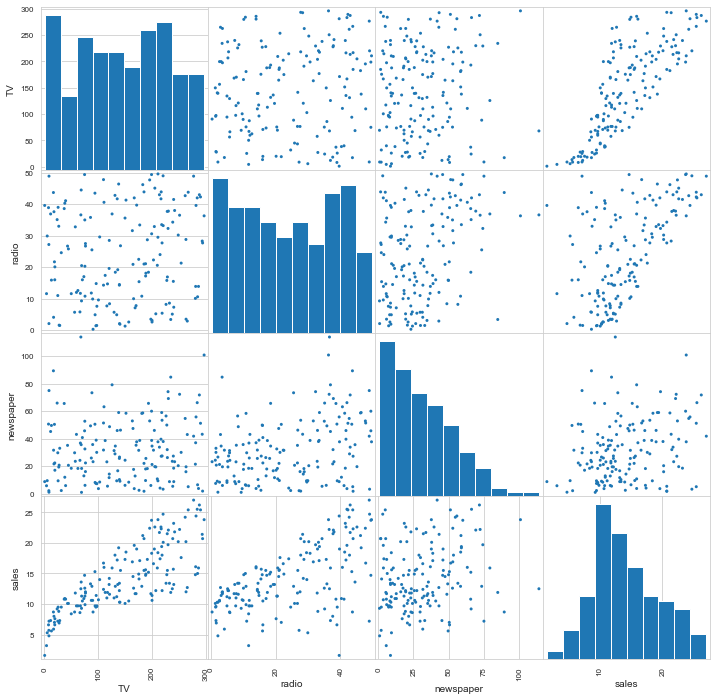

In [7]:
## first input the dataframe you want to see a 
## scatter matrix for
## then enter figsize and other plotting arguments
scatter_matrix(ads_train, figsize = (12,12), alpha = 1)

plt.show()

There definitely appears to be some relationship between `sales` and `TV` as well as `sales` and `radio`. For now we'll treat these as linear relationships, but stay tuned.

It seems that a reasonable starting model would be
$$
\text{sales} = \beta_0 + \beta_1 \text{TV} + \beta_2 \text{radio} + \epsilon
$$
Let's fit the coefficients using the formula we just learned before just using `sklearn` or `statsmodels`.

In [8]:
## make X
X_train = np.ones([len(ads_train),3])
X_train[:,1] = np.array(ads_train.TV)
X_train[:,2] = np.array(ads_train.radio)

## Make y
y_train = np.array(ads_train.sales)

## Calculate beta_hat
beta_hat = np.linalg.inv(X_train.transpose().dot(X_train)).dot(X_train.transpose()).dot(y_train)

In [9]:
print("beta_0_hat is",np.round(beta_hat[0],5))
print("beta_1_hat is",np.round(beta_hat[1],5))
print("beta_2_hat is",np.round(beta_hat[2],5))

beta_0_hat is 2.77262
beta_1_hat is 0.0474
beta_2_hat is 0.18783


#### You Code

Use `statsmodels` and `sklearn` to fit the model we just fit by hand. 

In [10]:
## Import the packages we'll need here

## Sample Answer
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [11]:
## Fit the model using statsmodels here
## Be sure to print out the table

## Sample Answer
fit = sm.OLS(ads_train['sales'],sm.add_constant(ads_train[['TV','radio']])).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     760.5
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           1.70e-81
Time:                        12:13:42   Log-Likelihood:                -305.72
No. Observations:                 160   AIC:                             617.4
Df Residuals:                     157   BIC:                             626.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7726      0.322      8.602      0.0

In [12]:
## Fit the model using sklearn here
## store your model object in reg

## Sample Answer
reg = LinearRegression(copy_X = True)

reg.fit(ads_train[['TV','radio']],ads_train['sales'])

LinearRegression()

In [13]:
## Print out the coefficients and the intercept 
## from the sklearn model here

## Sample Answer
print("beta_0_hat is",np.round(reg.intercept_,5))
print("beta_1_hat is",np.round(reg.coef_[0],5))
print("beta_2_hat is",np.round(reg.coef_[1],5))

beta_0_hat is 2.77262
beta_1_hat is 0.0474
beta_2_hat is 0.18783


In [14]:
## We can use sklearn to make a prediction on the
## training data as well, do so here

## Sample Answer
pred = reg.predict(ads_train[['TV','radio']])

#### A Note Before Continuing: A Slight Change in Interpretation

We can still interpret the fit, but the specific details are slightly different. Let's interpret $\hat{\beta_1}$, this has been estimated as $0.04645$. We can interpret this as:

<i>for a $1$ unit increase in TV holding all other variables constant, we estimate a $0.04645$ increase in sales.</i>



### Plotting the Regression

This is more difficult with multiple features. Because we only have two features we can make a $3$-D plot like so.

The code below will produce a mesh grid of input values for `TV` and `radio`. We'll then use that grid to generate the model predictions and plot them in a 3-D graph.

In [15]:
## get the prediction this is where meshgrid comes in handy
x1s = np.linspace(ads_train.TV.min(), ads_train.TV.max(), 10)
x2s = np.linspace(ads_train.radio.min(), ads_train.radio.max(), 10)

## this makes a meshgrid
x1v, x2v = np.meshgrid(x1s, x2s)

## combine x1v and x2v into a single array for prediction
X_grid = np.concatenate([x1v.reshape(-1,1), x2v.reshape(-1,1)], axis=1)

## predict at each grid point
pred_grid = reg.predict(X_grid)

## add the predictions to the grid array
X_grid = np.concatenate([X_grid, pred_grid.reshape(-1,1)], axis=1)

<IPython.core.display.Javascript object>


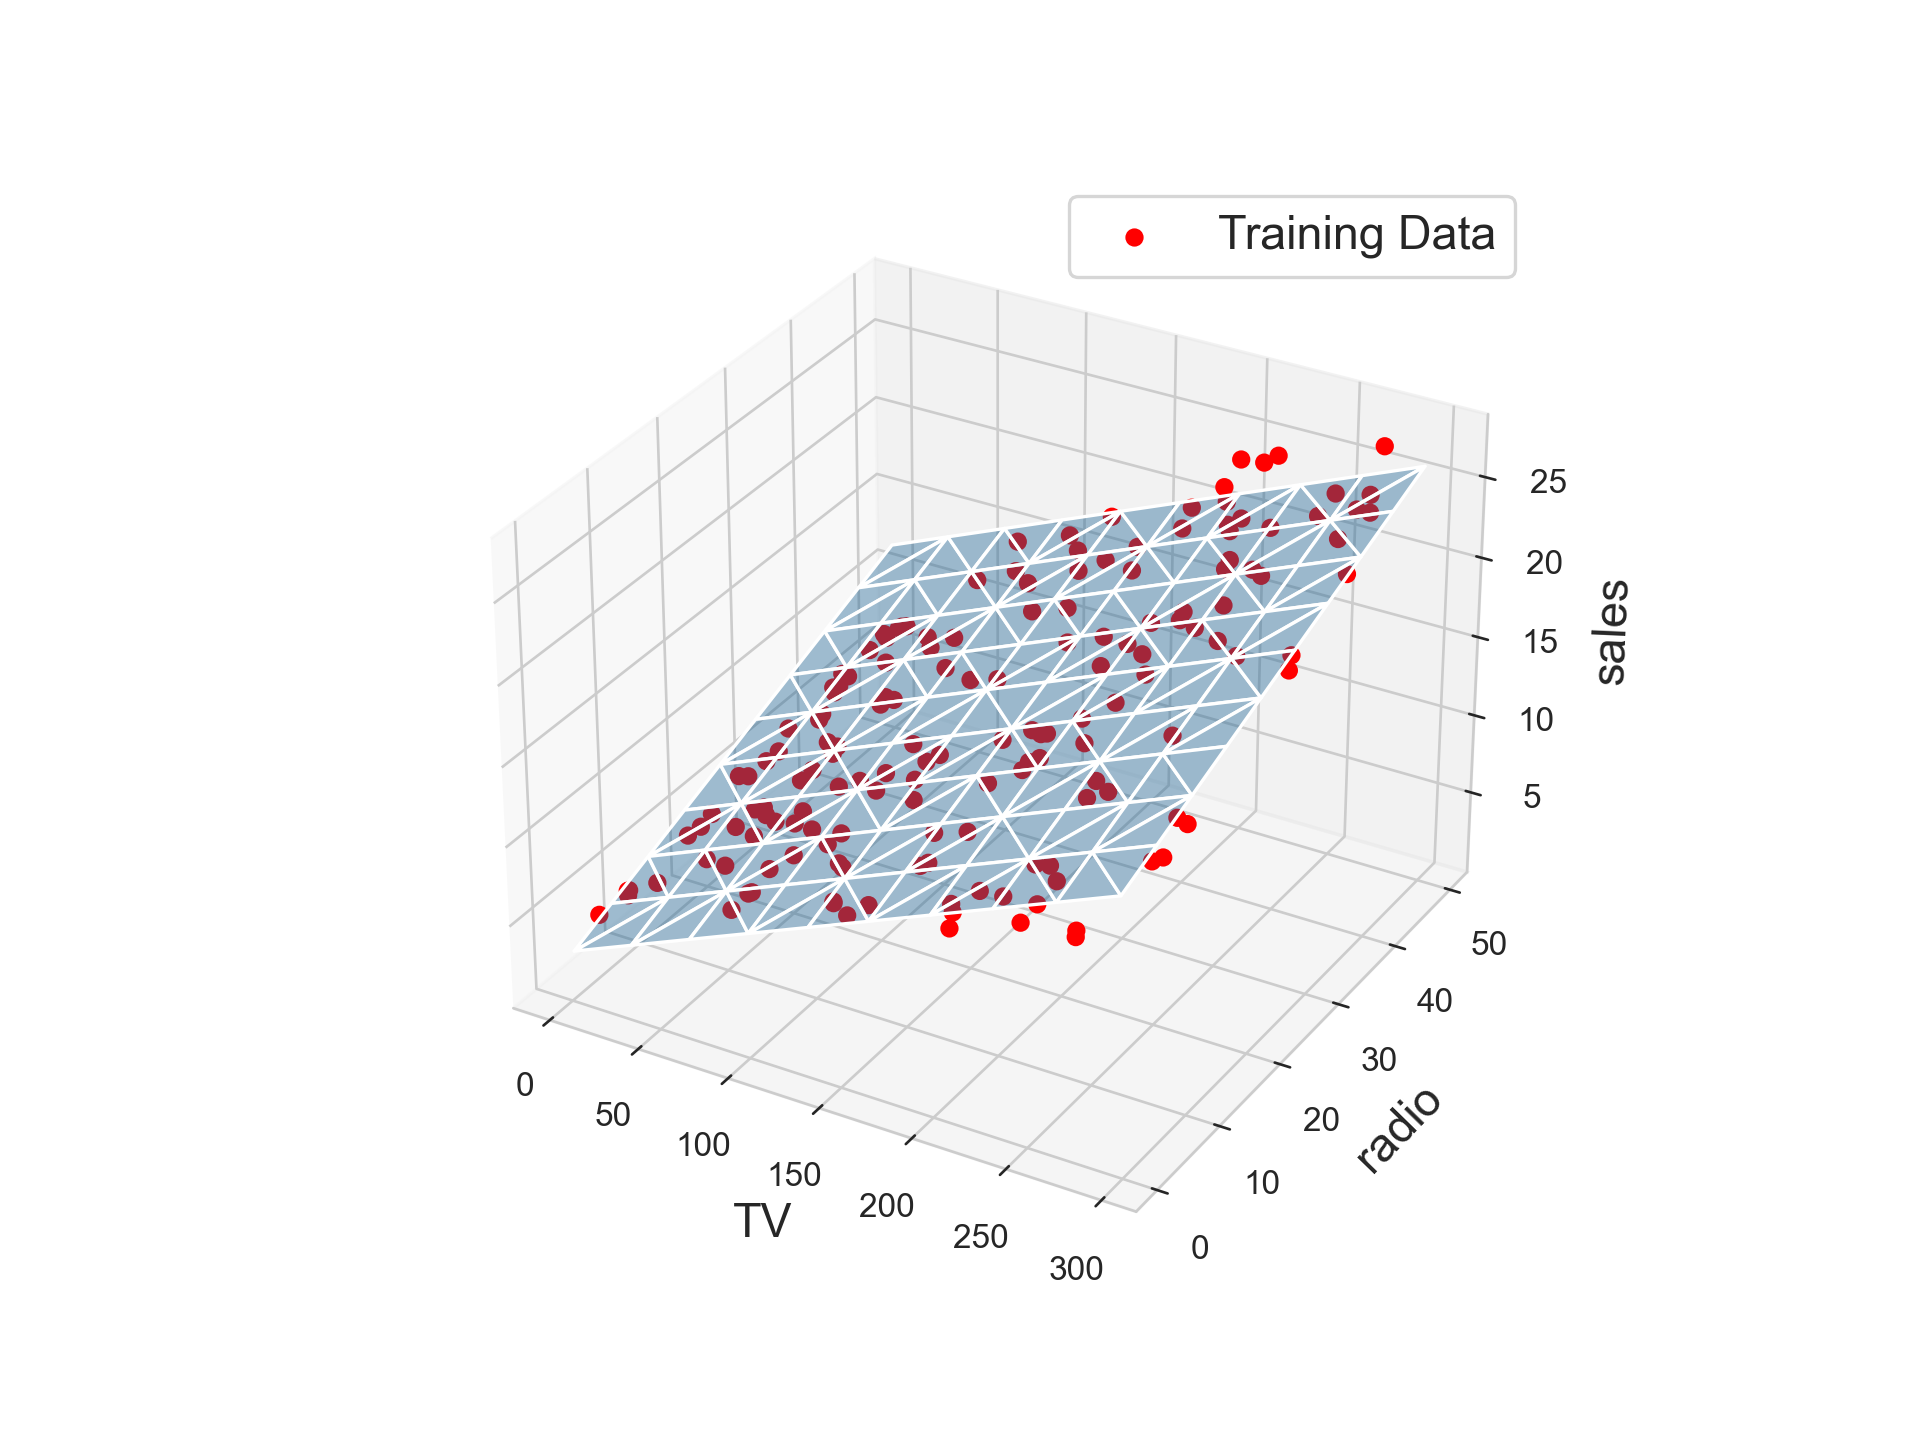

In [99]:
%matplotlib notebook
## Now we plot the regression plane
## along with the training observations

## Make a figure object
fig = plt.figure(figsize=(8,6))

## We'll add a 3d subplot object
ax = fig.add_subplot(111, projection='3d')

## plot_trisurf makes a surface out of triangles
## it will take in the TV grid on the x-axis
## the radio grid on the y-axis
## and the prediction grid on the z-axis
## alpha <1 allows us to see through the surface
ax.plot_trisurf(X_grid[:, 0], X_grid[:, 1], X_grid[:,2], alpha=0.4)

## scatter will plot the observations from the training set
ax.scatter(ads_train['TV'], ads_train['radio'], ads_train['sales'], c="r", alpha=1, label="Training Data")

## Add labels
ax.set_xlabel("TV", fontsize=14)
ax.set_ylabel("radio", fontsize=14)
ax.set_zlabel("sales", fontsize=14)

plt.legend(fontsize=14)

plt.show()

You can rotate the plot and examine how well we fit the data with our model. As you rotate it does seem like the residuals may not be random, so perhaps our model was not the best choice. We'll examine this more closely in later in the notebook when we introduce transformations of features and interaction terms.

In [100]:
# We have to do this because of
# the %matplotlib notebook argument in the above code block
plt.close()

### You Code

Return once again to the `carseats` data set. Examine the continuous features using correlations and scatter plots and produce a MLR model to predict `Sales`. Just use your best judgement, it's okay if you don't produce the best model right now. We will be touching on model selection later.

Note you can read about the variables in `carseats` here, <a href="https://rdrr.io/cran/ISLR/man/Carseats.html">https://rdrr.io/cran/ISLR/man/Carseats.html</a>.

In [18]:
## Read in the carseats data
carseats = pd.read_csv("carseats.csv")

## Make the same train test split as the last notebook
carseats_train = carseats.copy().sample(frac=.75,random_state = 440)
carseats_test = carseats.copy().drop(carseats_train.index)

<IPython.core.display.Javascript object>


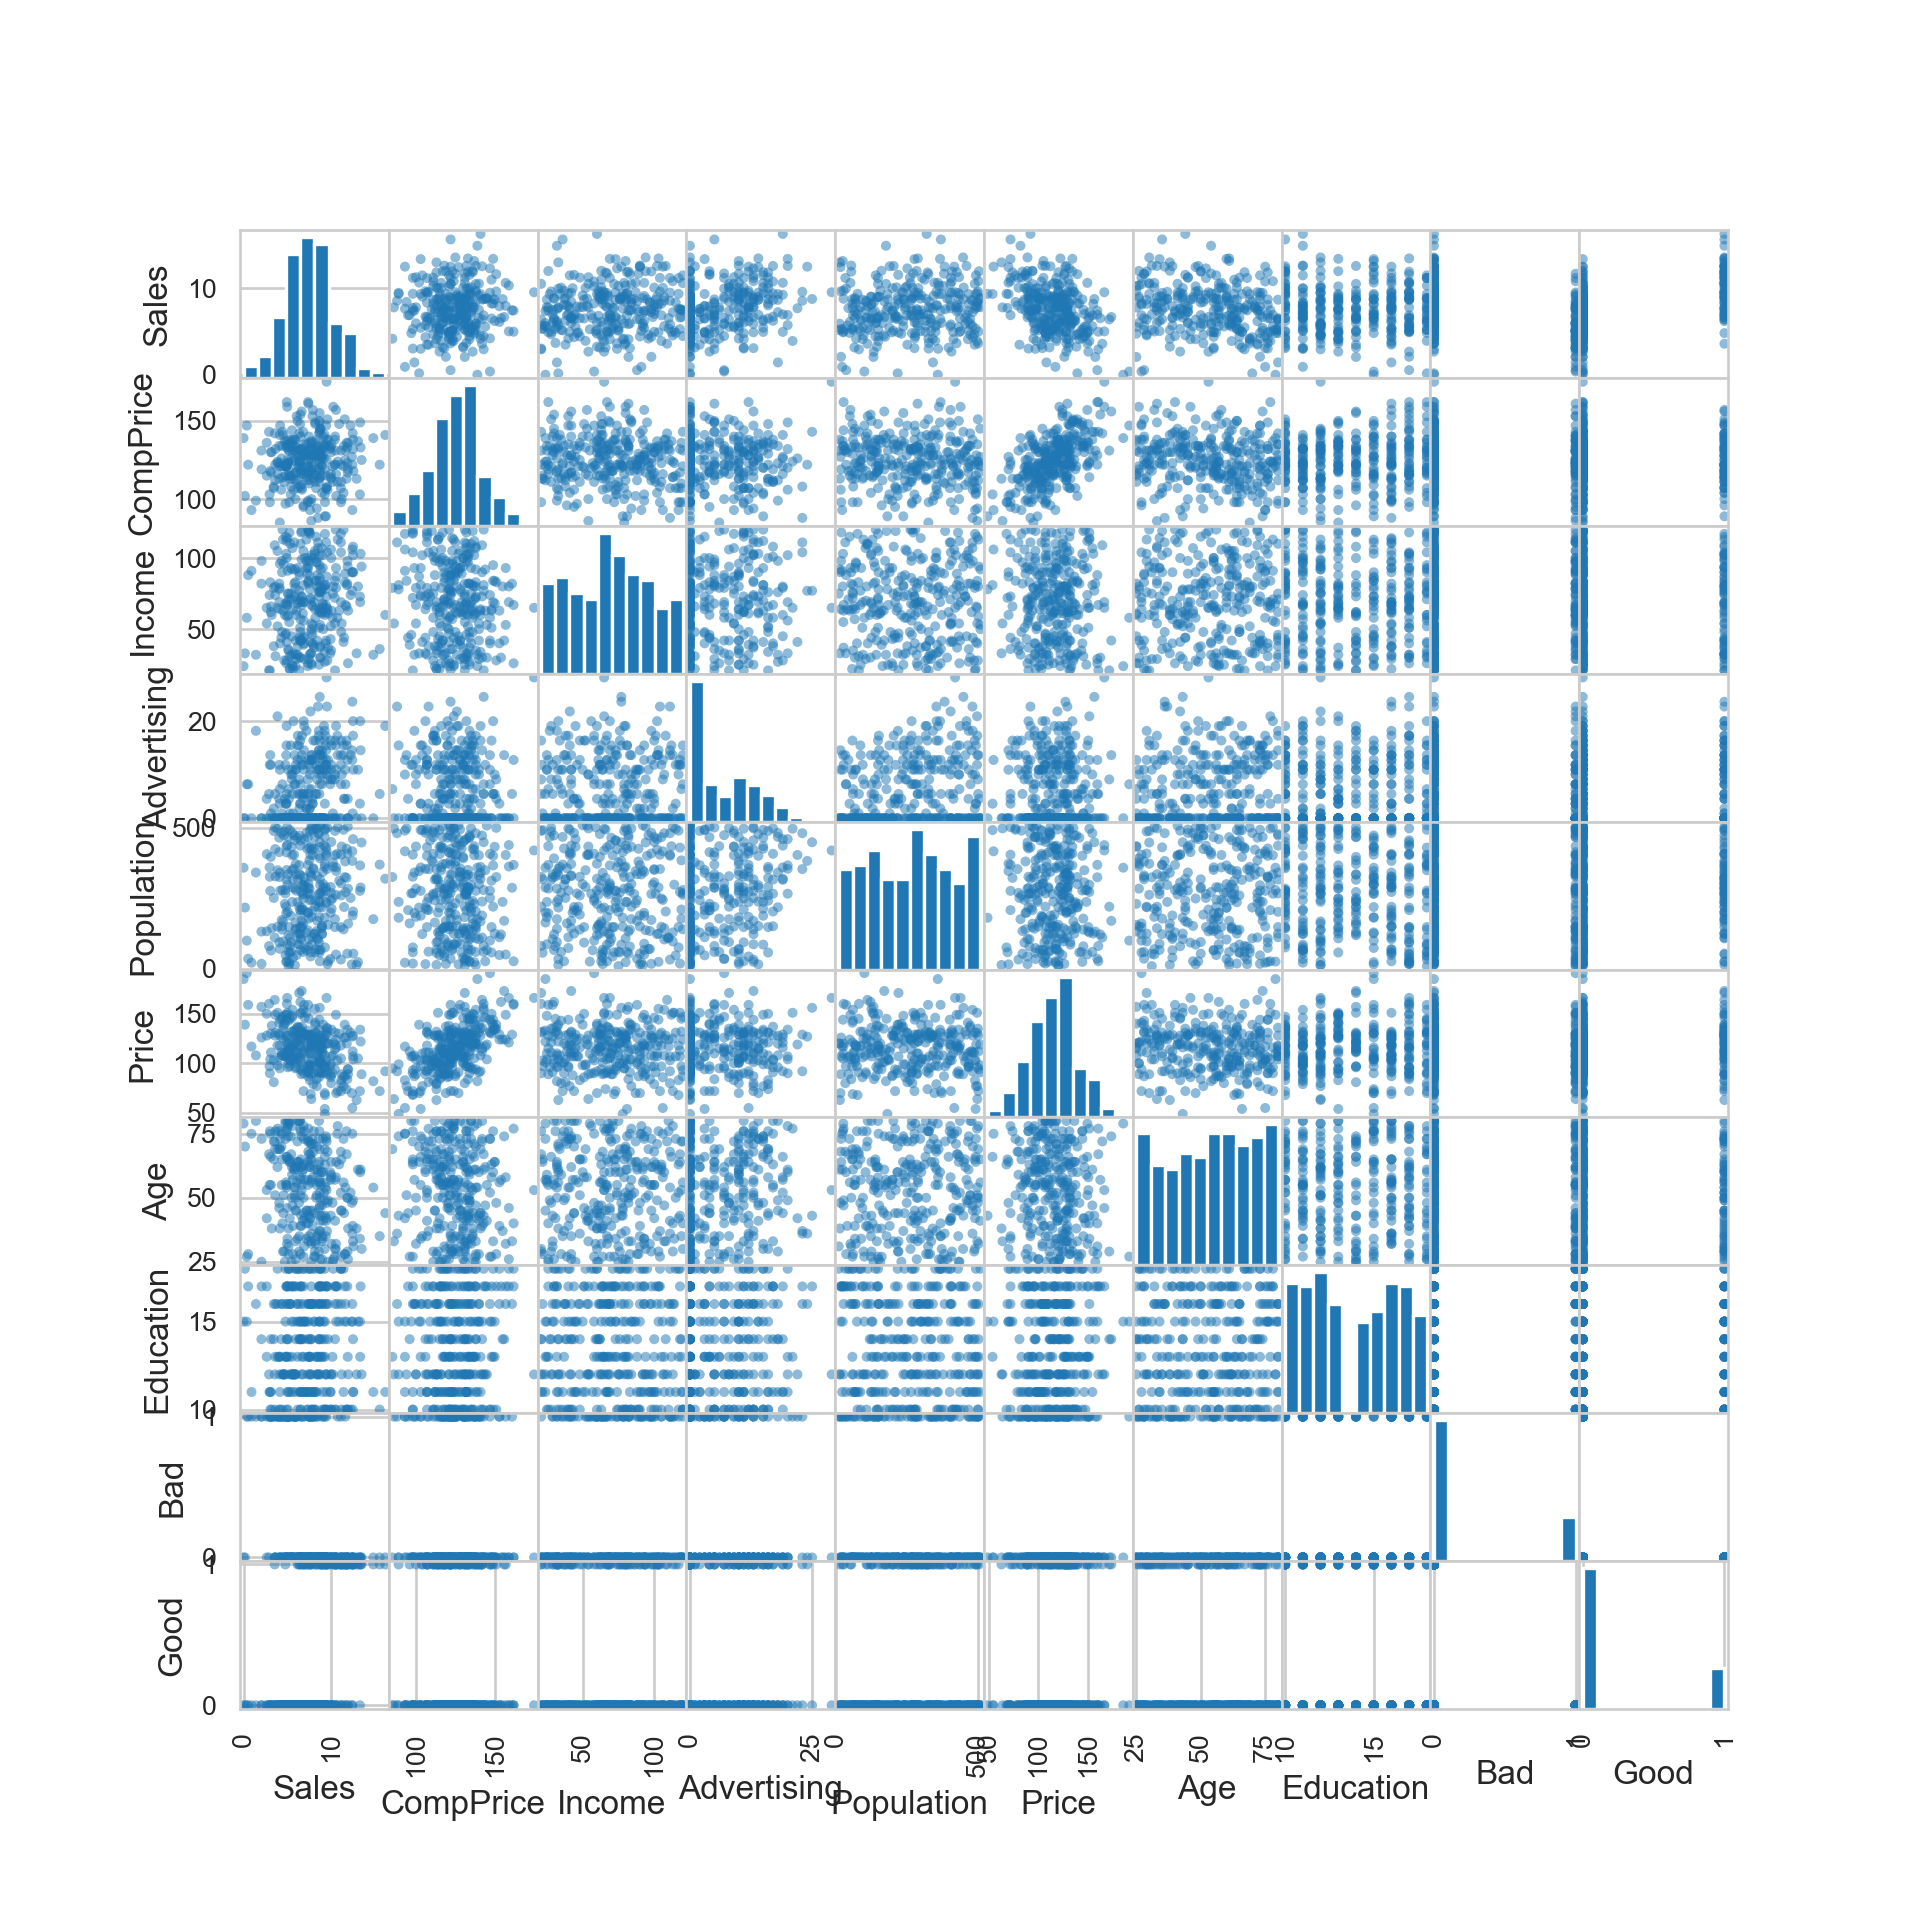

In [101]:
## Try plotting a scatter matrix here

## Sample Answer
scatter_matrix(carseats_train,figsize=(8,8))

plt.show()

In [102]:
## You'll need to run this after
plt.close()

In [21]:
## Fit a Model here

## Sample Answer
# One model Guess, Sales ~ Price + Advertising + Age?
fit = sm.OLS(carseats_train['Sales'], 
                 sm.add_constant(carseats_train[['Price','Advertising','Age']])).fit()

print(fit.summary())


print()
print("The training MSE is", np.sum(np.power(fit.resid,2))/len(carseats_train))

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     55.28
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           2.12e-28
Time:                        12:13:44   Log-Likelihood:                -667.95
No. Observations:                 300   AIC:                             1344.
Df Residuals:                     296   BIC:                             1359.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          15.6759      0.817     19.180      

In [22]:
## Code here

## Sample Answer for the above model, just in sklearn
mlr = LinearRegression(copy_X = True)


mlr.fit(carseats_train[['Price','Advertising','Age']],carseats_train['Sales'])

print(mlr.intercept_)
print(mlr.coef_)

15.675878468002352
[-0.05341371  0.13899581 -0.05369354]


## Dealing with Qualitative Predictors with Beer Data

Now that we have a grasp of how MLR works with continuous predictors let's examine how we can also include qualitative predictors like binary or categorical features.

To do this we'll look at `beer.csv`, our goal is to model `IBU`.

In [23]:
## Read in the csv
beers = pd.read_csv("beer.csv")

print("There are", len(beers), "observations in the data set.")
print("The columns are", beers.columns)

## Check the percentage of each Beer_Type to
## see if we need to stratify our train test split
beers.Beer_Type.value_counts(normalize=True)

There are 347 observations in the data set.
The columns are Index(['Beer_Name', 'IBU', 'ABV', 'Rating', 'Beer_Type'], dtype='object')


IPA      0.56196
Stout    0.43804
Name: Beer_Type, dtype: float64

In [24]:
## train test split
beers_copy = beers.copy()

beers_train = beers_copy.sample(frac=.75,random_state = 614)
beers_test = beers_copy.drop(beers_train.index)

In [25]:
## Sanity check to see our percentages are close 
## to the same as the original
beers_train.Beer_Type.value_counts(normalize=True)

IPA      0.557692
Stout    0.442308
Name: Beer_Type, dtype: float64

### Why Add Qualitative Data to Regression

Now why might we want to add in this qualitative data? Because it can add more context. Let's use `seaborn`'s `lmplot` to demonstrate with the `beer` data.

<IPython.core.display.Javascript object>


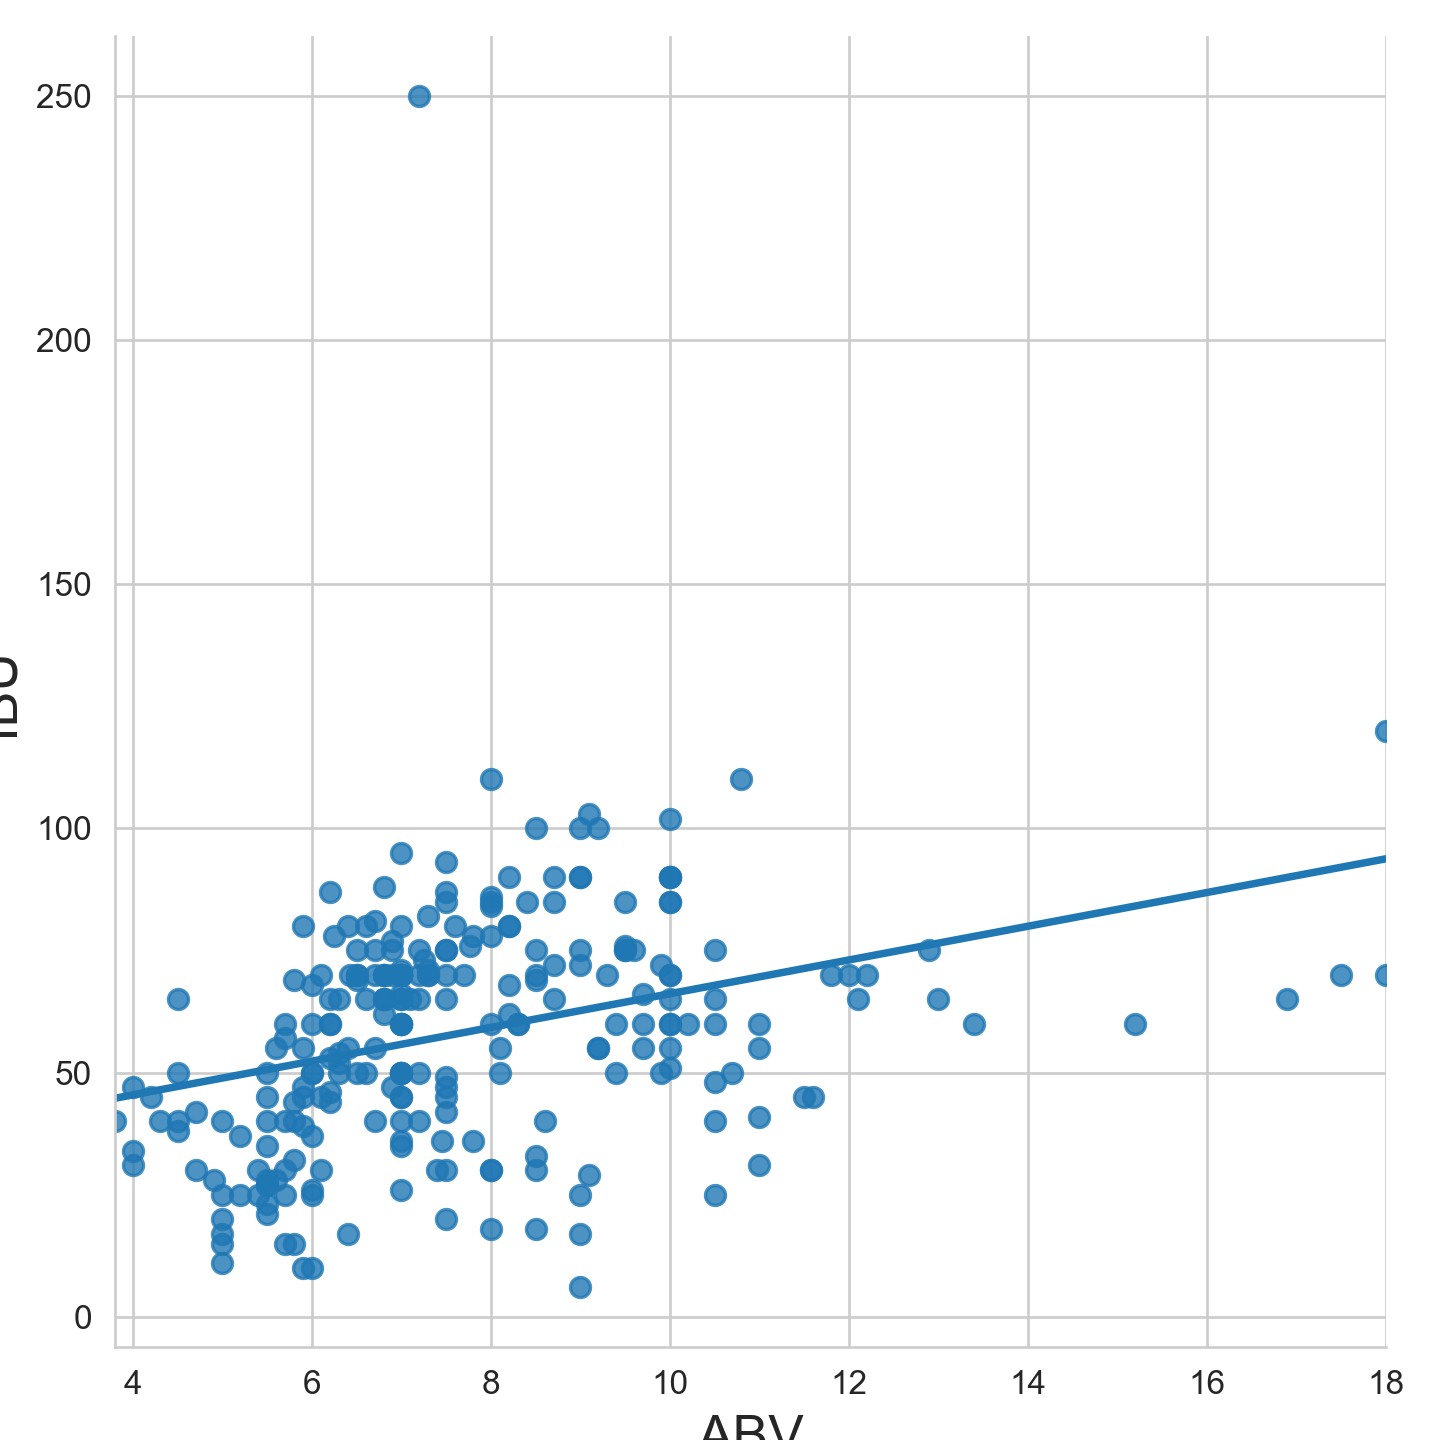

In [103]:
## First plot a normal regression of ibu on abv
sns.lmplot(data = beers_train, x="ABV", y="IBU", 
           height=6, ci = False)

plt.xlabel("ABV", fontsize=16)
plt.ylabel("IBU", fontsize=16)

plt.show()

In [104]:
plt.close()

<IPython.core.display.Javascript object>


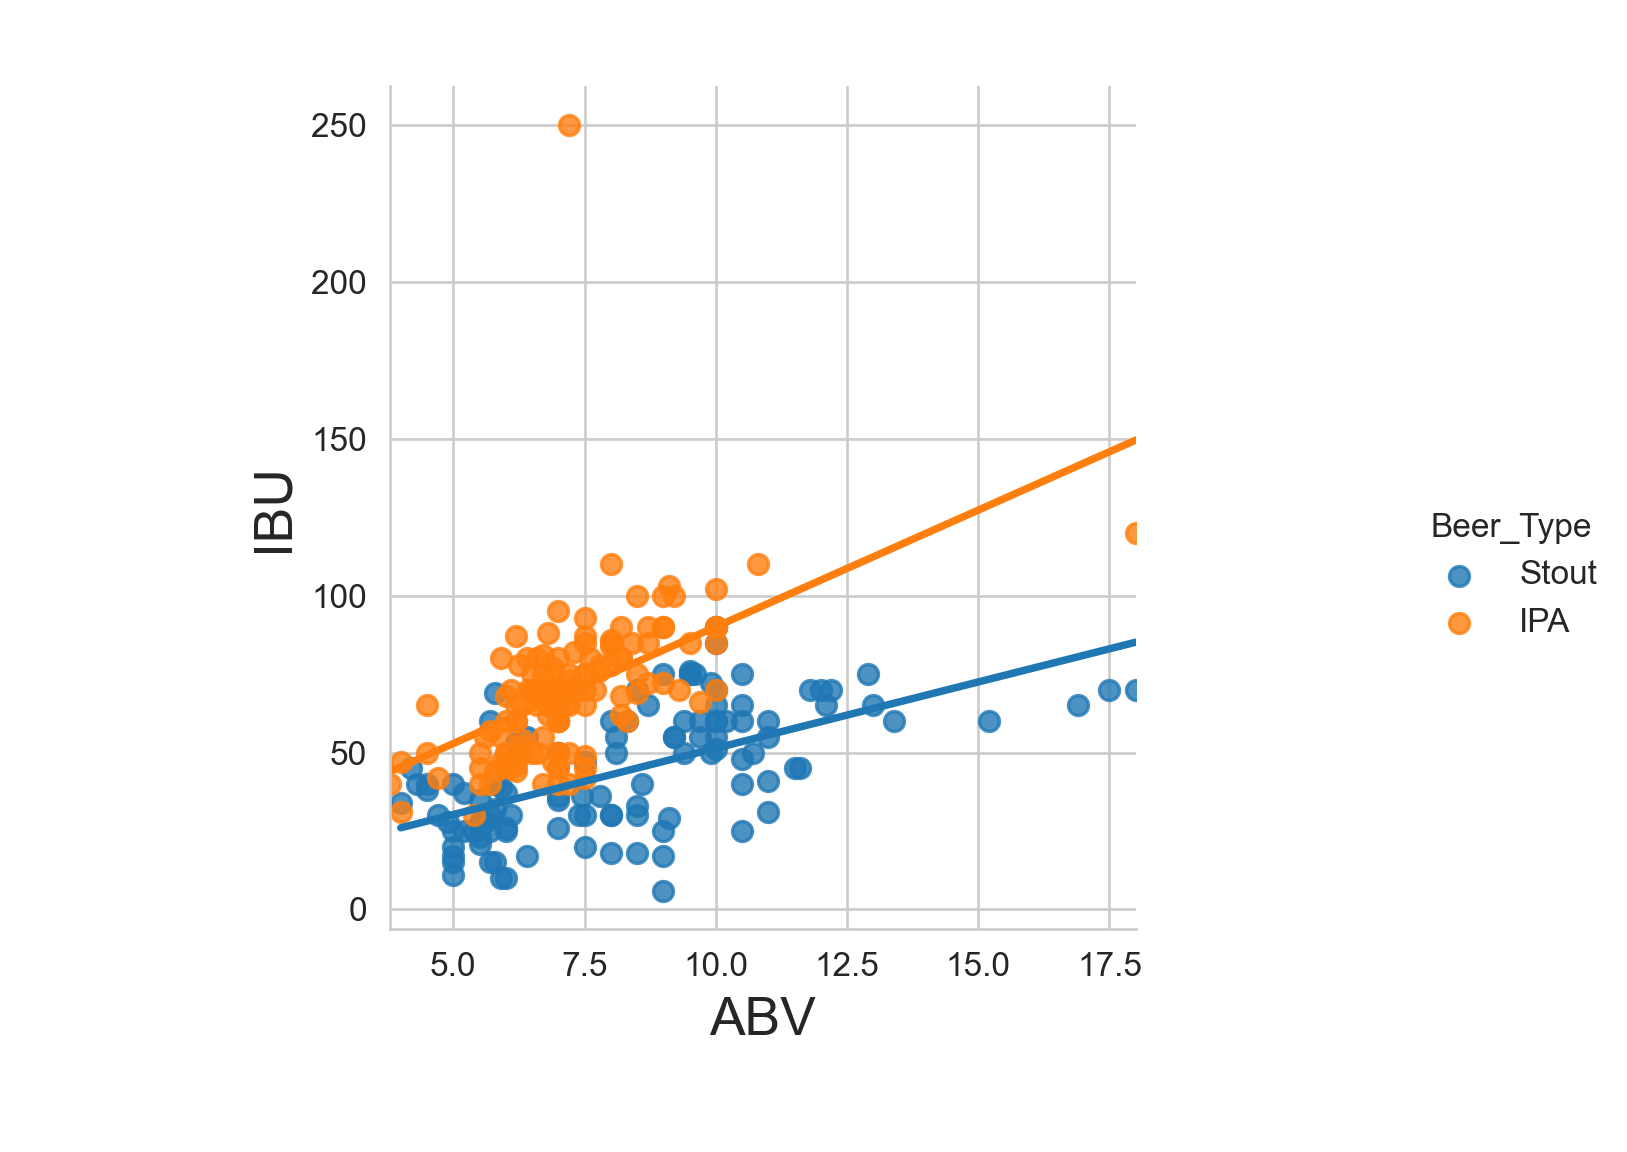

In [105]:
# now plot a regression with "hue" listed as Beer_Type
sns.lmplot(data = beers_train, x="ABV", y="IBU", 
           hue = "Beer_Type", height=2,  
           ci = False)

plt.xlabel("ABV", fontsize=16)
plt.ylabel("IBU", fontsize=16)

plt.show()

In [106]:
plt.close()

So the idea is that while there may exist a linear relationship between `ABV` and `IBU`, it is possible that the exact relationship is different based on the type of beer you're looking at.

Making a `lmplot` is one way to see if there is an effect from a qualitative variable, but it isn't always feasible, especially with a lot of possible qualitative values. Another way to probe for an effect is with a box and whisker plot.

<IPython.core.display.Javascript object>


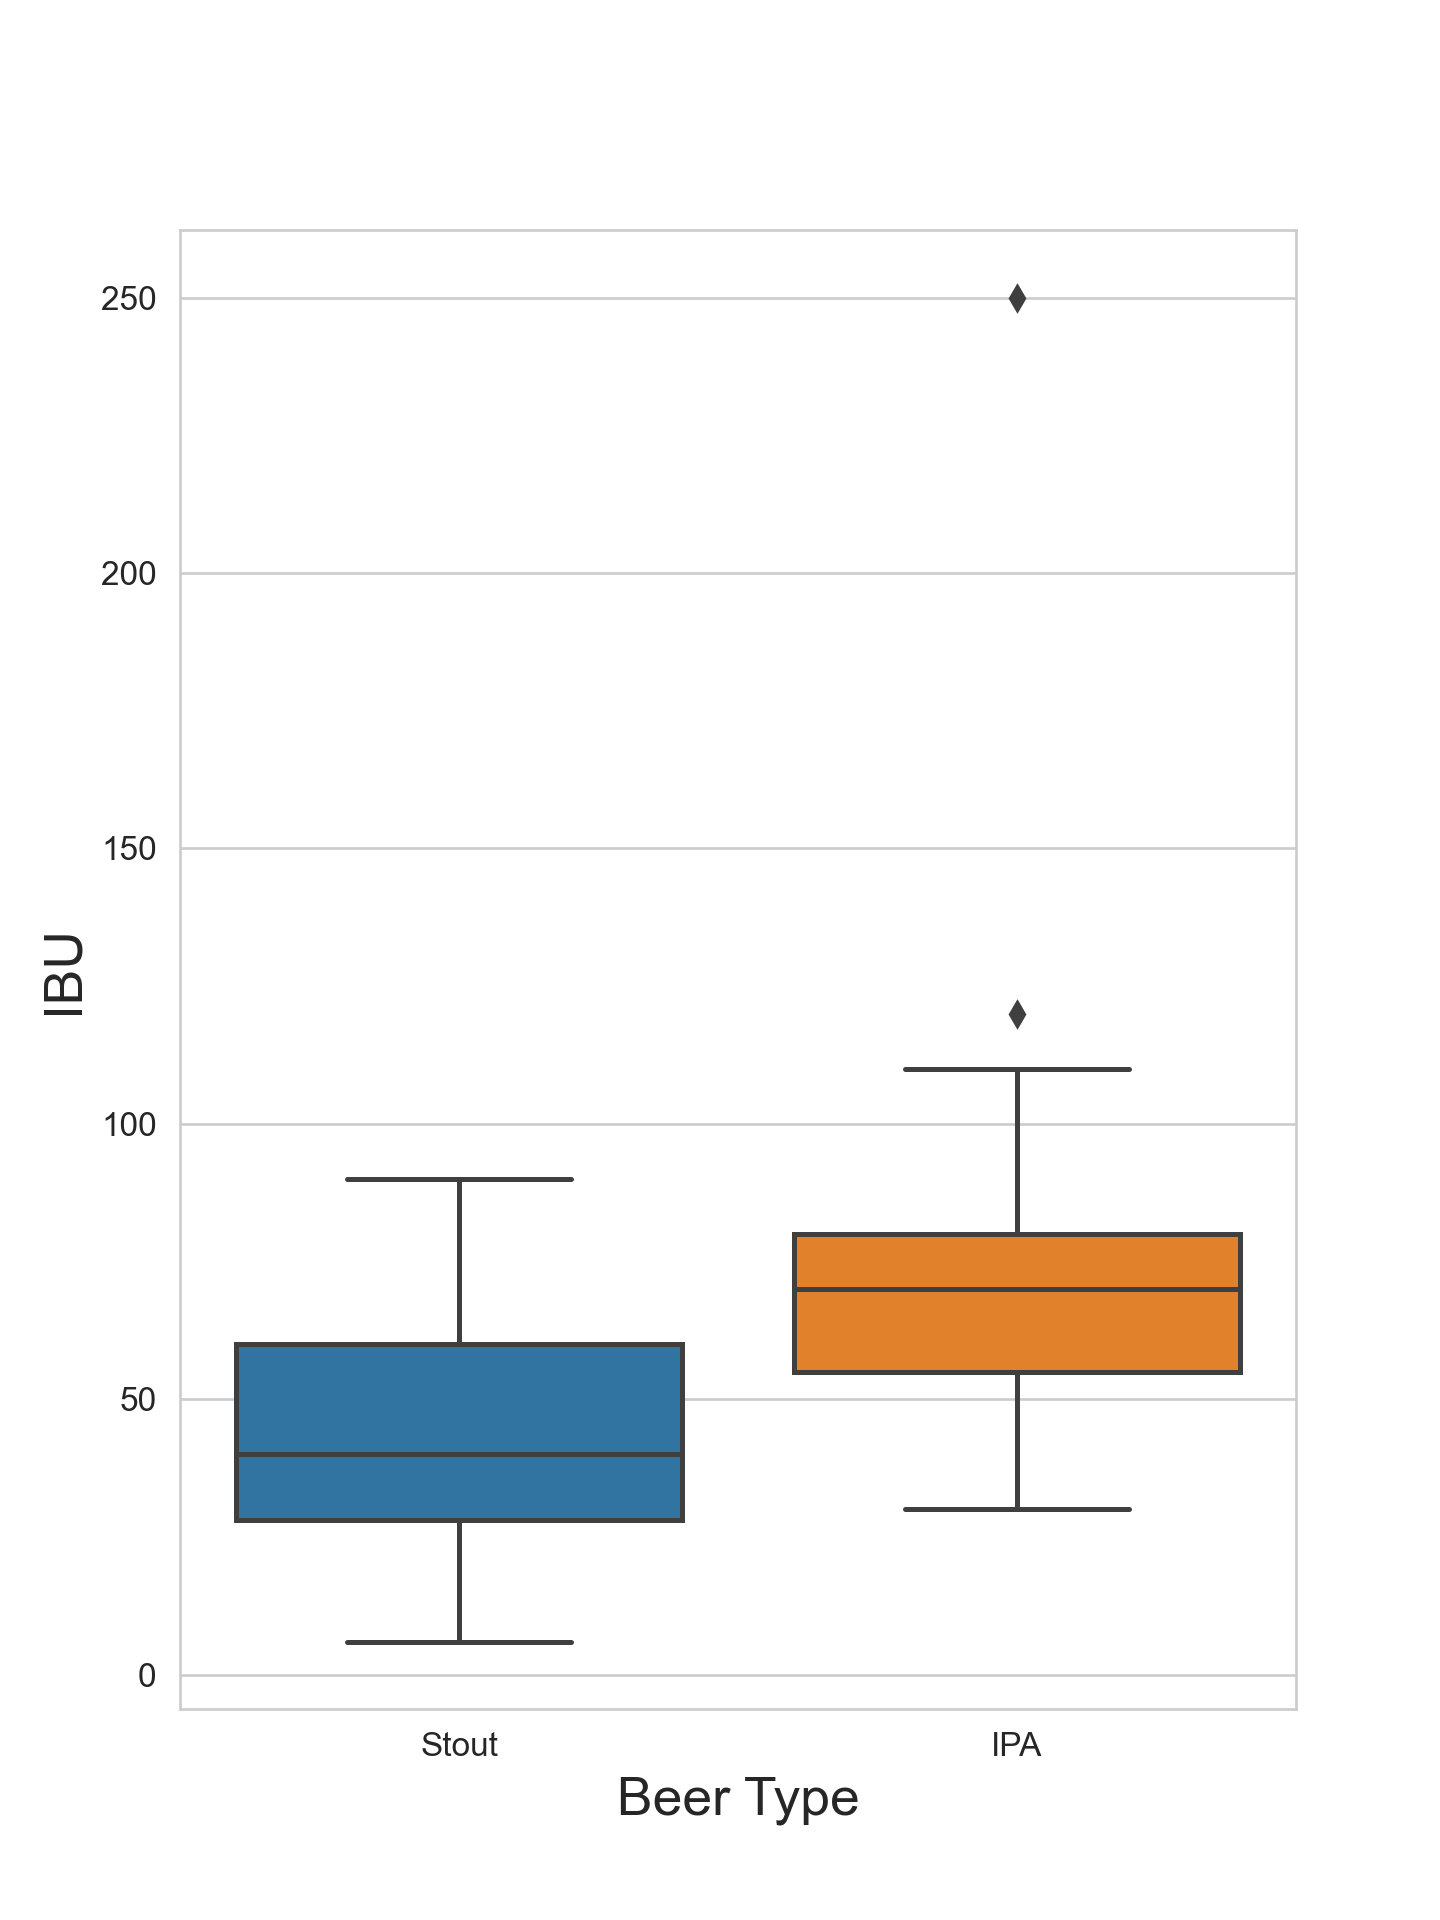

In [107]:
# We'll use seaborn to make this
fig,ax = plt.subplots(figsize=(6,8))

# boxplot takes in the data, the x-axis variable, the y-axis variable
# and produces a box and whisker plot
sns.boxplot(data = beers_train,x = "Beer_Type",y = "IBU",ax=ax)

plt.xlabel("Beer Type", fontsize = 16)
plt.ylabel("IBU", fontsize = 16)

plt.show()

In [108]:
plt.close()

A box plot is a way of showing the distribution of a continuous variable. The bottom of each box shows the $25^\text{th}$ percentile of the distribution, the middle line shows the median of the distribution, and the $75^\text{th}$ percentile of the distribution. 

For the `beers` data our plot shows that the distribution of `IBU` is slightly different by `Beer_Type`. Giving more evidence that we may want to include `Beer_Type` as a qualitative feature in the model.


### How to Include Qualitative Features - One-Hot Encoding

We cannot just include the `Beer_Type` variable in the model like `reg.fit(beers_train[['ABV','Beer_Type']],beers_train['IBV'])` because our features must be numeric not strings. So we must change our strings into numbers. The way this is done in general is called <i>one-hot encoding</i>.

#### How to One-Hot Encode

In general suppose your qualitative variable, $Q$, has $k$ possible values. In our example $k = 2$. Then you create $k-1$ new indicator variables,
$$
1_{l,i} = \left\lbrace \begin{array}{c c}
    0 & \text{if } Q_i \neq l \\
    1 & \text{if } Q_i = l
\end{array} \right.,
$$
for $l$ being any of the first $k-1$ $k$ possible values, and where $i$ denotes the $i^\text{th}$ observation in the data set. By the process of elimination if each of the $k-1$ $1_l$ are $0$ then the value of $Q$ must be the $k^\text{th}$ possible value.

So for our `beers` data we would create a `Stout` indicator that is $1$ if the beer is a `Stout` and $0$ if not.

<i>Note: We only need $k-1$ indicators because of the process of elimination. In our example we only need $1$ indicator because if an observation is not a stout we know it is an ipa, and vice versa. Pay careful attention to the number of indicators you use in your model, this is a common mistake new modelers make.</i>

Let's see how to create this in `python`.

In [32]:
## We can do it by hand
## First set all beers as 0 for the variable Stout
beers_train['Stout'] = 0

## Then locate all the stouts and set Stout to 1
beers_train.loc[beers_train.Beer_Type == "Stout",'Stout'] = 1

In [33]:
beers_train.head(10)

Beer_Name  IBU   ABV  Rating Beer_Type  \
54                   Shakespeare Oatmeal Stout   60   5.7   3.722     Stout   
3                                Dragon’s Milk   31  11.0   4.062     Stout   
281                     Road 2 Ruin Double IPA   78   8.0   3.836       IPA   
292                        Hercules Double IPA   85  10.0   3.831       IPA   
345                                White Rajah   70   6.8   4.015       IPA   
339                           The Immortal IPA   54   6.3   3.679       IPA   
205                          Pineapple Sculpin   70   7.0   3.798       IPA   
66       Brewer's Reserve Bourbon Barrel Stout   48  10.5   4.201     Stout   
82                                Cocoa Psycho   85  10.0   3.943     Stout   
132  Stochasticity Project: Master of Disguise   55   9.7   3.834     Stout   

     Stout  
54       1  
3        1  
281      0  
292      0  
345      0  
339      0  
205      0  
66       1  
82       1  
132      1

In [34]:
## By hand is easy for a binary option, but
## tedious for variables with many categories
## in that case pandas.get_dummies is useful
## https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html, docs

pd.get_dummies(beers_train['Beer_Type'])

IPA  Stout
54     0      1
3      0      1
281    1      0
292    1      0
345    1      0
..   ...    ...
286    1      0
103    0      1
187    1      0
69     0      1
5      0      1

[260 rows x 2 columns]

In [35]:
## For us we'd only keep the `Stout` column
beers_train['Stout'] = pd.get_dummies(beers_train['Beer_Type'])['Stout']

In [36]:
beers_train.head(10)

Beer_Name  IBU   ABV  Rating Beer_Type  \
54                   Shakespeare Oatmeal Stout   60   5.7   3.722     Stout   
3                                Dragon’s Milk   31  11.0   4.062     Stout   
281                     Road 2 Ruin Double IPA   78   8.0   3.836       IPA   
292                        Hercules Double IPA   85  10.0   3.831       IPA   
345                                White Rajah   70   6.8   4.015       IPA   
339                           The Immortal IPA   54   6.3   3.679       IPA   
205                          Pineapple Sculpin   70   7.0   3.798       IPA   
66       Brewer's Reserve Bourbon Barrel Stout   48  10.5   4.201     Stout   
82                                Cocoa Psycho   85  10.0   3.943     Stout   
132  Stochasticity Project: Master of Disguise   55   9.7   3.834     Stout   

     Stout  
54       1  
3        1  
281      0  
292      0  
345      0  
339      0  
205      0  
66       1  
82       1  
132      1

Now we are ready to fit the following model:
$$
\text{IBU} = \beta_0 + \beta_1 \text{ABV} + \beta_2 \text{Stout} + \epsilon
$$

In [110]:
## We'll use sklearn
reg = LinearRegression(copy_X = True)

## fit the model
reg.fit(beers_train[['ABV','Stout']],beers_train['IBU'])

LinearRegression()

In [111]:
print("beta_0_hat is",np.round(reg.intercept_,5))
print("beta_1_hat is",np.round(reg.coef_[0],5))
print("beta_2_hat is",np.round(reg.coef_[1],5))

beta_0_hat is 32.63203
beta_1_hat is 5.08177
beta_2_hat is -30.63135


<IPython.core.display.Javascript object>


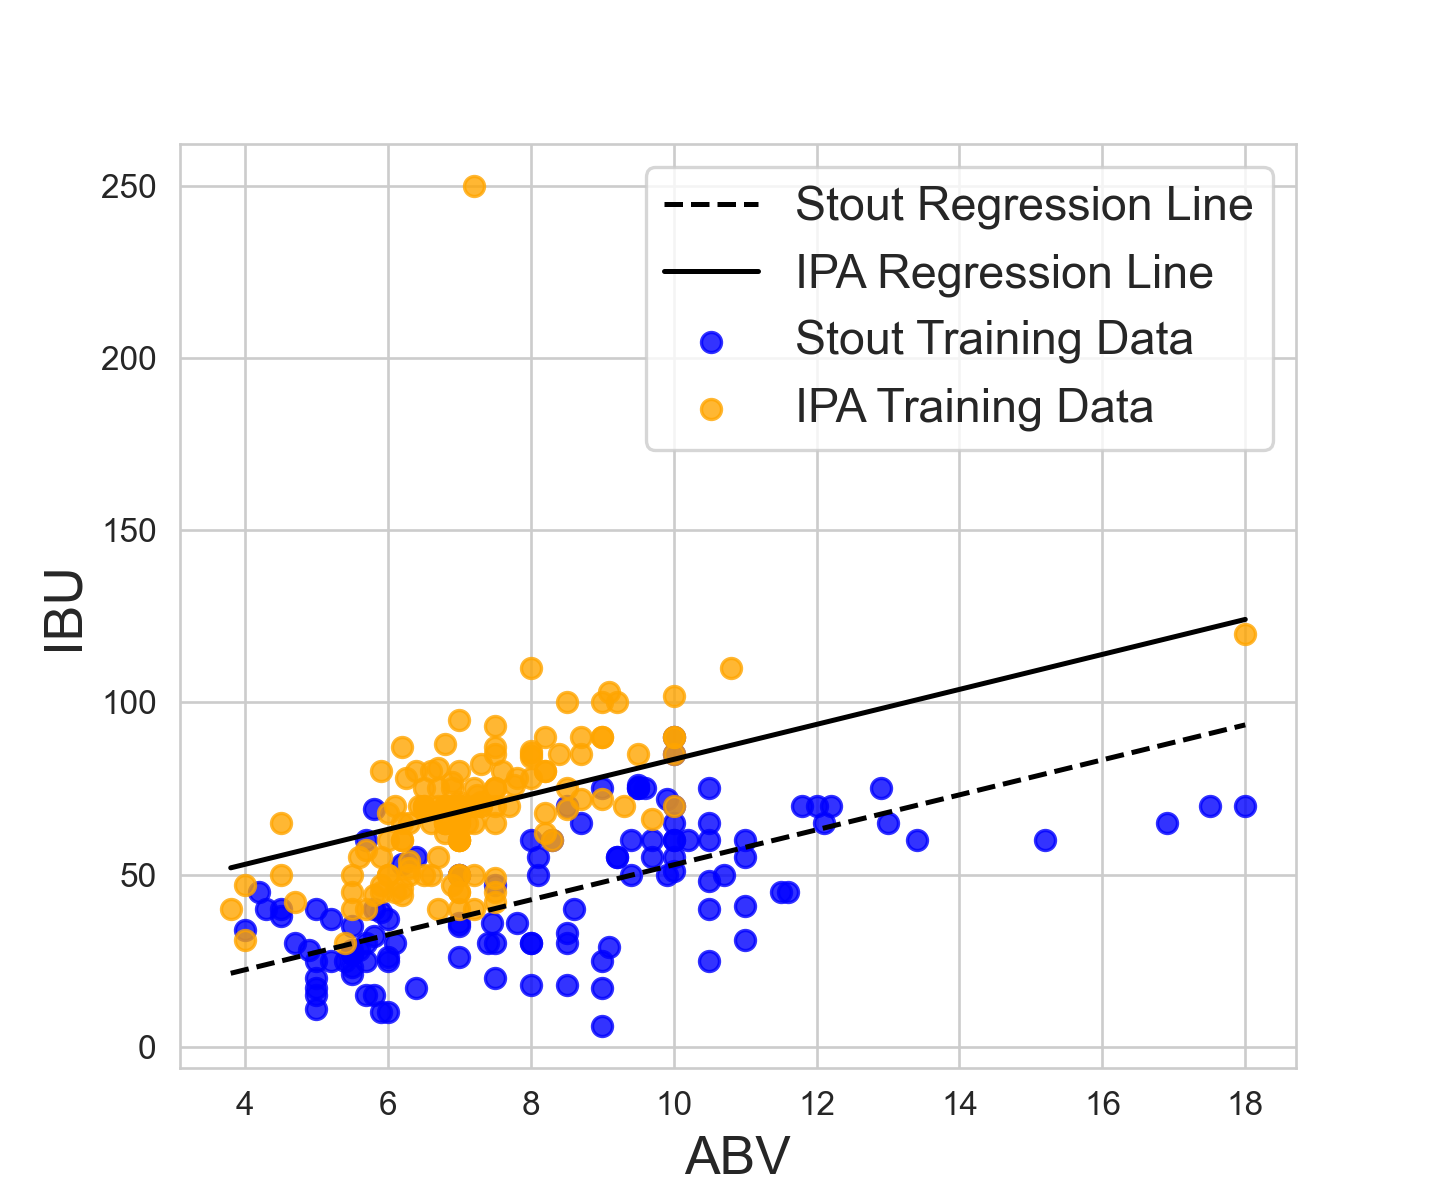

In [112]:
### Here we'll plot our regression line

## We can plot the two lines by limiting our prediction input
stout_values = np.ones((100,2))
stout_values[:,0] = np.linspace(beers_train['ABV'].min(),beers_train['ABV'].max(),100)

## make a stout prediction
stout_pred = reg.predict(stout_values)

## make ipa values
ipa_values = np.zeros((100,2))
ipa_values[:,0] = np.linspace(beers_train['ABV'].min(),beers_train['ABV'].max(),100)
ipa_pred = reg.predict(ipa_values)

## Let's plot
plt.figure(figsize=(6,5))

## plot stout values
plt.scatter(beers_train.loc[beers_train.Stout == 1,'ABV'], 
               beers_train.loc[beers_train.Stout == 1,'IBU'],
               c = 'blue', alpha = .8, label="Stout Training Data")

## plot the stout line
plt.plot(stout_values[:,0], stout_pred, "k--", label="Stout Regression Line")

## plot ipa values
plt.scatter(beers_train.loc[beers_train.Stout == 0,'ABV'], 
               beers_train.loc[beers_train.Stout == 0,'IBU'],
               c = 'orange', alpha = .8, label="IPA Training Data")

## plot the ipa line
plt.plot(ipa_values[:,0], ipa_pred, "k", label="IPA Regression Line")

plt.legend(fontsize = 14)

plt.xlabel("ABV",fontsize=16)
plt.ylabel("IBU",fontsize=16)

plt.show()

In [113]:
plt.close()

### Why isn't My Line the Same?

Now notice, this is NOT the line we produced above with the the `sns.lmplot` command. That's because we have not included the interaction between `ABV` and `Stout`. 

#### A Better Explanation - Look at the Model

Recall our model
$$
\text{IBU} = \beta_0 + \beta_1 \text{ABV} + \beta_2 \text{Stout} + \epsilon.
$$

When Stout $=0$ the intercept for our line is $\beta_0$. When Stout $=1$ the intercept becomes $\beta_0 + \beta_2$. But, notice in either case the slope of the line stays the same, $\beta_1$. If you look back at the `seaborn` plot we produced, the lines do not have the same slope. So clearly our statistical model is missing something that the `seaborn` model has. We'll return to this after you practice some coding.


### You Code

Take your model for the `carseats` data from earlier. Examine the feature labeled `ShelveLoc`. Does it appear that this qualitatve variable has an impact on `Sales`? Add this feature to the model you made earlier in the notebook.

In [114]:
## Examine ShelveLoc here

## Sample answer
sns.boxplot(data = carseats, x = 'ShelveLoc', y = 'Sales')

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


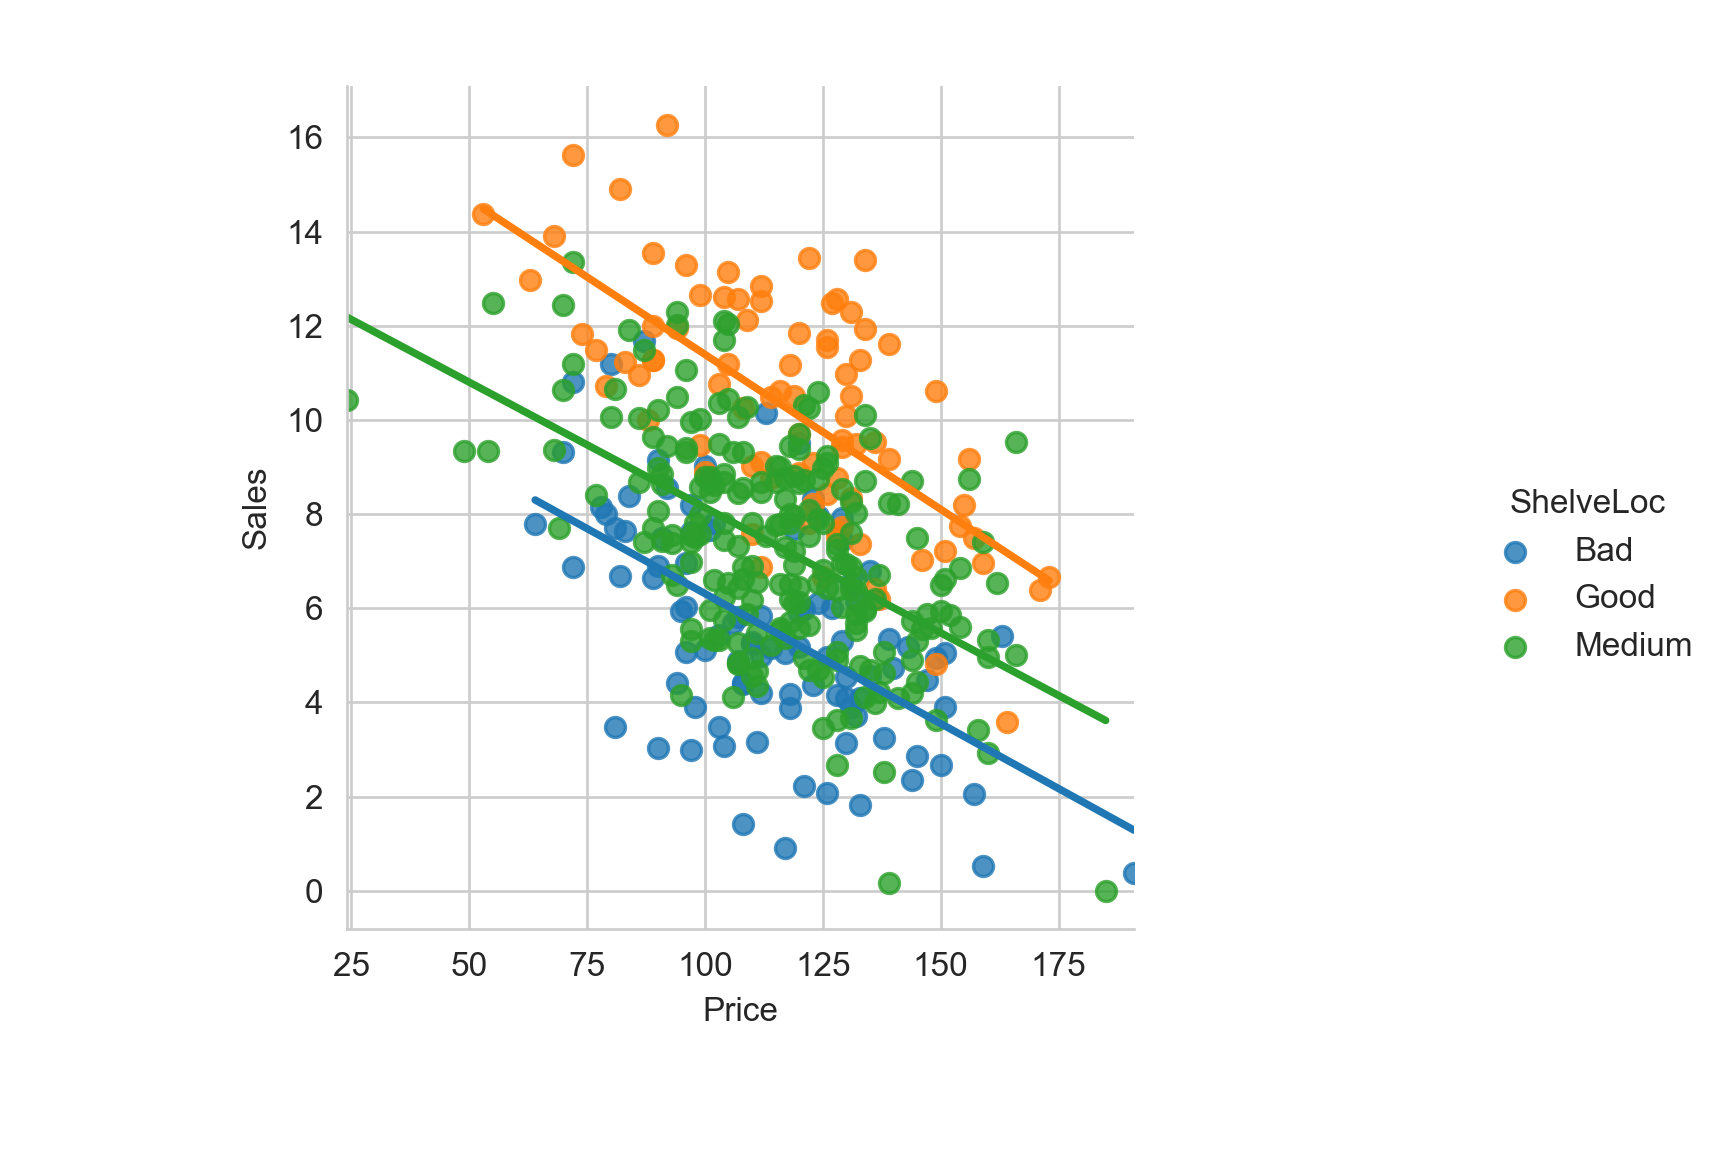

In [115]:
## Sample Answer cont.
plt.close()

sns.lmplot(data = carseats, x = 'Price', y = 'Sales', 
           hue = 'ShelveLoc', ci = False, height=2)

plt.show()

In [116]:
plt.close()

In [117]:
## Make indicator variables here

## Sample Answer
carseats_train[['Bad','Good']] = pd.get_dummies(carseats_train['ShelveLoc'])[['Bad','Good']]

In [118]:
## Fit your model with indicators here

## Find the training MSE
fit = sm.OLS(carseats_train['Sales'],
                sm.add_constant(carseats_train[['Price','Advertising',
                                                'Age','Bad','Good']])).fit()

print(fit.summary())



print()
print("The training MSE is", np.sum(np.power(fit.resid,2))/len(carseats_train))

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     121.2
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           2.79e-69
Time:                        12:20:32   Log-Likelihood:                -566.85
No. Observations:                 300   AIC:                             1146.
Df Residuals:                     294   BIC:                             1168.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          16.3787      0.599     27.338      

## Interaction Terms

Let's return to our issue with the beer regression line.

Remember the model we fit:
$$
\text{IBU} = \beta_0 + \beta_1 \text{ABV} + \beta_2 \text{Stout} + \epsilon.
$$

We noted that this model only allows for different intercepts for Stouts and IPAs, but not slopes. 


However if we add in the term $\beta_3 \text{Stout} \times \text{ABV}$ like so,
$$
\text{IBU} = \beta_0 + \beta_1 \text{ABV} + \beta_2 \text{Stout} + \beta_3 \text{Stout} \times \text{ABV} + \epsilon
$$

then when Stout $=0$ the slope of the line is $\beta_1$ and when Stout $=1$ the slope of the line $\beta_1 + \beta_3$. The $\text{Stout} \times \text{ABV}$ is the interaction term between Stout and ABV.

<i>Note in the Regression Homework Sets you are asked to interpret the coefficient estimates for this model.</i>

Let's make an interaction term and then fit this new model with `sklearn`.

In [119]:
## make the interaction term
beers_train['Stout_ABV'] = beers_train['Stout']*beers_train['ABV']

In [120]:
## You make and fit the model here
## use sklearn and store the model in reg
reg = LinearRegression(copy_X = True)

reg.fit(beers_train[['ABV','Stout','Stout_ABV']],beers_train['IBU'])

LinearRegression()

In [121]:
print("beta_0_hat is",np.round(reg.intercept_,5))
print("beta_1_hat is",np.round(reg.coef_[0],5))
print("beta_2_hat is",np.round(reg.coef_[1],5))
print("beta_3_hat is",np.round(reg.coef_[2],5))

beta_0_hat is 15.68659
beta_1_hat is 7.43576
beta_2_hat is -6.54521
beta_3_hat is -3.213


In [122]:
### Again this code will plot the lines, don't worry about it
### for now

## We can plot the two lines by limiting our prediction input
stout_values = np.ones((100,3))

## make the ABV values
stout_values[:,0] = np.linspace(beers_train['ABV'].min(),beers_train['ABV'].max(),100)

## now the interaction term
stout_values[:,2] = stout_values[:,0]*stout_values[:,1]

## make a stout prediction
stout_pred = reg.predict(stout_values)

## make ipa values
ipa_values = np.zeros((100,3))
ipa_values[:,0] = np.linspace(beers_train['ABV'].min(),beers_train['ABV'].max(),100)
ipa_values[:,2] = ipa_values[:,0]*ipa_values[:,1]
ipa_pred = reg.predict(ipa_values)


## Let's plot
plt.figure(figsize=(6,5))

## plot stout values
plt.scatter(beers_train.loc[beers_train.Stout == 1,'ABV'], 
               beers_train.loc[beers_train.Stout == 1,'IBU'],
               c = 'blue', alpha = .8, label="Stout Training Data")

## plot the stout line
plt.plot(stout_values[:,0], stout_pred, "k--", label="Stout Regression Line")

## plot ipa values
plt.scatter(beers_train.loc[beers_train.Stout == 0,'ABV'], 
               beers_train.loc[beers_train.Stout == 0,'IBU'],
               c = 'orange', alpha = .8, label="IPA Training Data")

## plot the ipa line
plt.plot(ipa_values[:,0], ipa_pred, "k", label="IPA Regression Line")

plt.legend(fontsize = 14)

plt.xlabel("ABV",fontsize=16)
plt.ylabel("IBU",fontsize=16)

plt.show()

<IPython.core.display.Javascript object>

In [123]:
plt.close()

Now this looks more like the `seaborn.lmplot`!

Adding interaction terms can also help with non-random residual plots as we'll see in a next example of this notebook.

### You Code

Load the following data set called `inter`. Build a regression model regressing $y$ on $x_1$ and $x_2$.

In [124]:
inter = pd.read_csv("inter.csv")

inter.head()

x1      x2          y
0 -2.056531   apple  -8.992339
1 -1.167136   apple  -6.325200
2 -1.896866  bottom   6.834594
3  0.510482   apple   0.153273
4 -2.481386   apple -10.380488

<IPython.core.display.Javascript object>


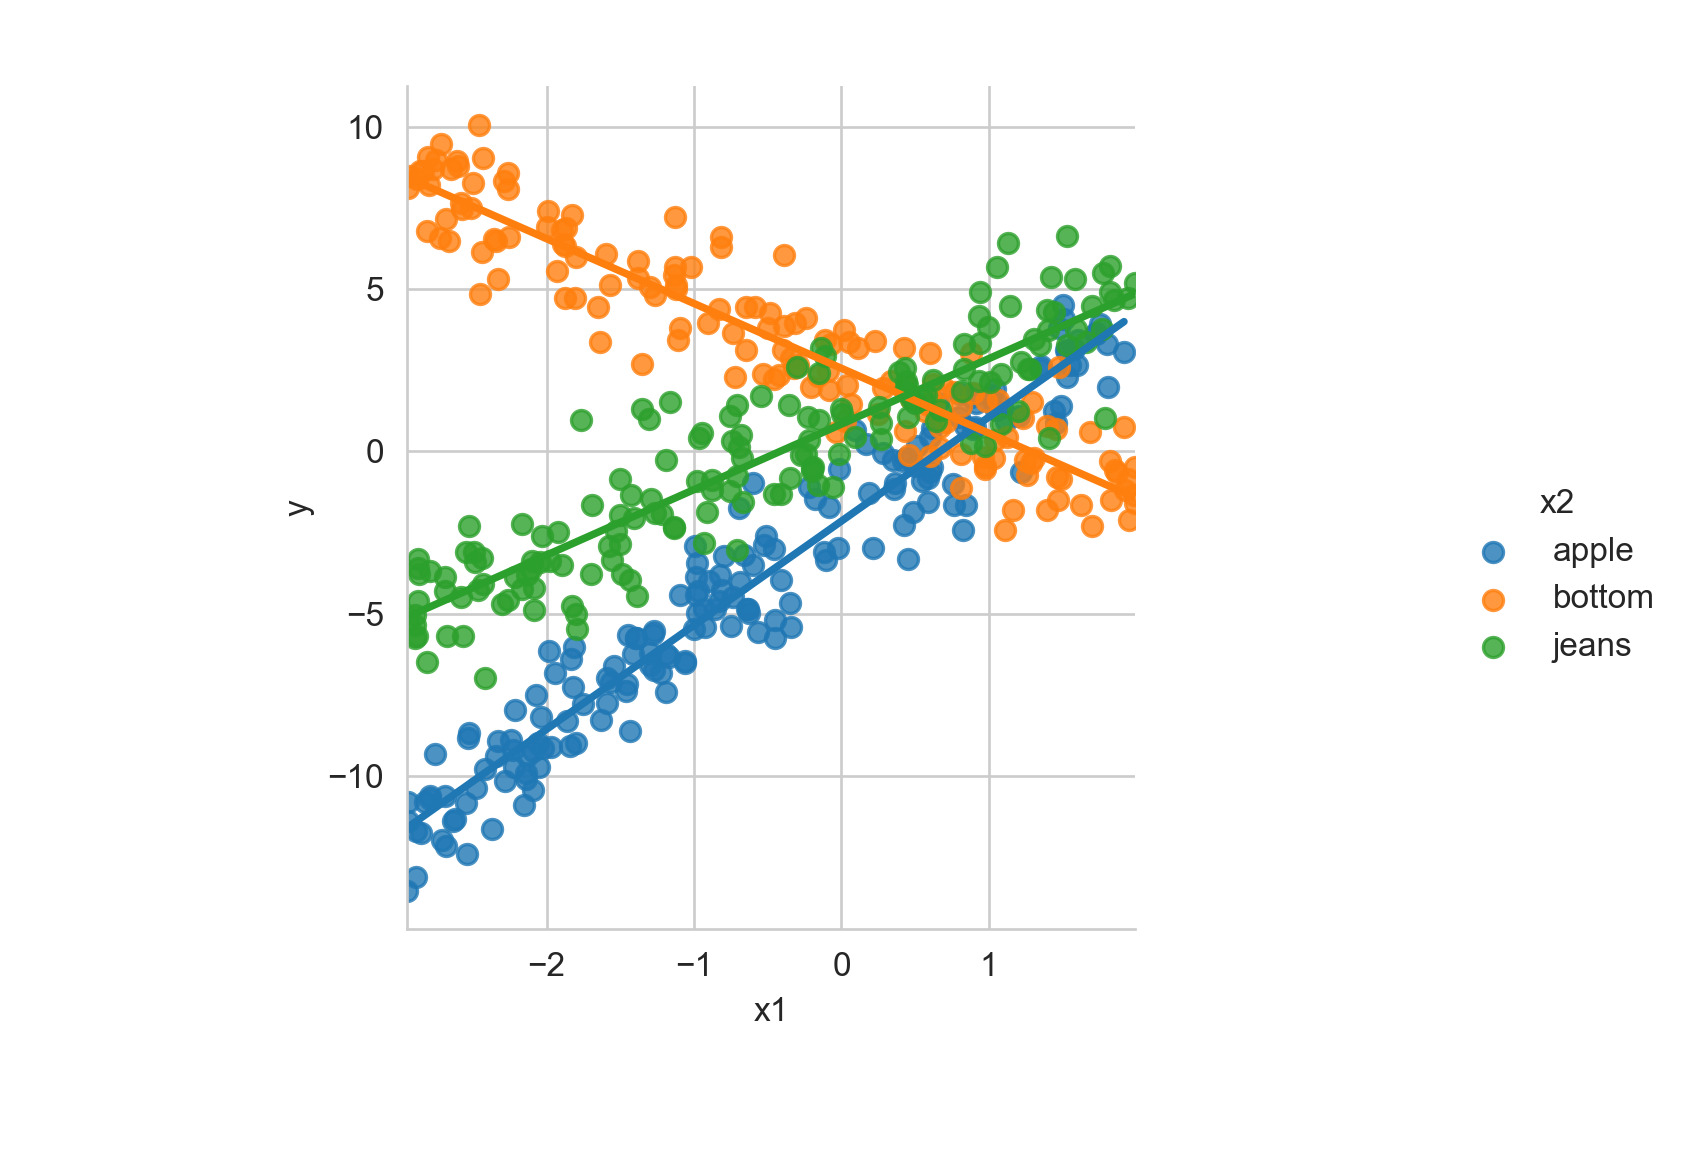

In [131]:
## Explore the categorical variable x2 with
## sns.lmplot here

## Sample Answer
sns.lmplot(data = inter, x='x1',y='y',hue='x2',ci=False,height=2)

plt.show()

In [132]:
plt.close()

In [128]:
## Get the appropriate indicator and interaction terms here

## Sample Answer
inter[['apple','jeans']] = pd.get_dummies(inter['x2'])[['apple','jeans']]
inter['x1_apple'] = inter['x1']*inter['apple']
inter['x1_jeans'] = inter['x1']*inter['jeans']

In [129]:
## Fit the model here

## Sample Answer
## my model was y ~ x1 + apple + apple*x1 + jeans + jeans*x1 + beta0
reg = LinearRegression(copy_X = True)

reg.fit(inter[['x1','apple','jeans','x1_apple','x1_jeans']],inter['y'])

print(reg.intercept_)
print(reg.coef_)

2.55822459900307
[-1.99759019 -4.70715129 -1.71871176  5.20538796  4.01576311]


## Polynomial Regression

Now not every relationship in the world is a line or a plane. 

Let's look at a synthetic dataset and see an example.

In [130]:
df = pd.read_csv("poly.csv")

print("There are",len(df),"observations.")
print("The columns are",df.columns)

There are 500 observations.
The columns are Index(['x1', 'x2', 'y'], dtype='object')


In [57]:
# Make the train test split
df_copy = df.copy()

df_train = df_copy.sample(frac=.75,random_state = 614)
df_test = df_copy.drop(df_train.index)

In [58]:
df_train.head()

x1        x2          y
219  2.289796  0.969242  -1.645074
34   5.703718  2.225895  22.938733
271  2.822881 -1.875427  22.887059
274  6.860596  0.954968  43.949767
111  6.902944 -1.728164  56.122324

<IPython.core.display.Javascript object>


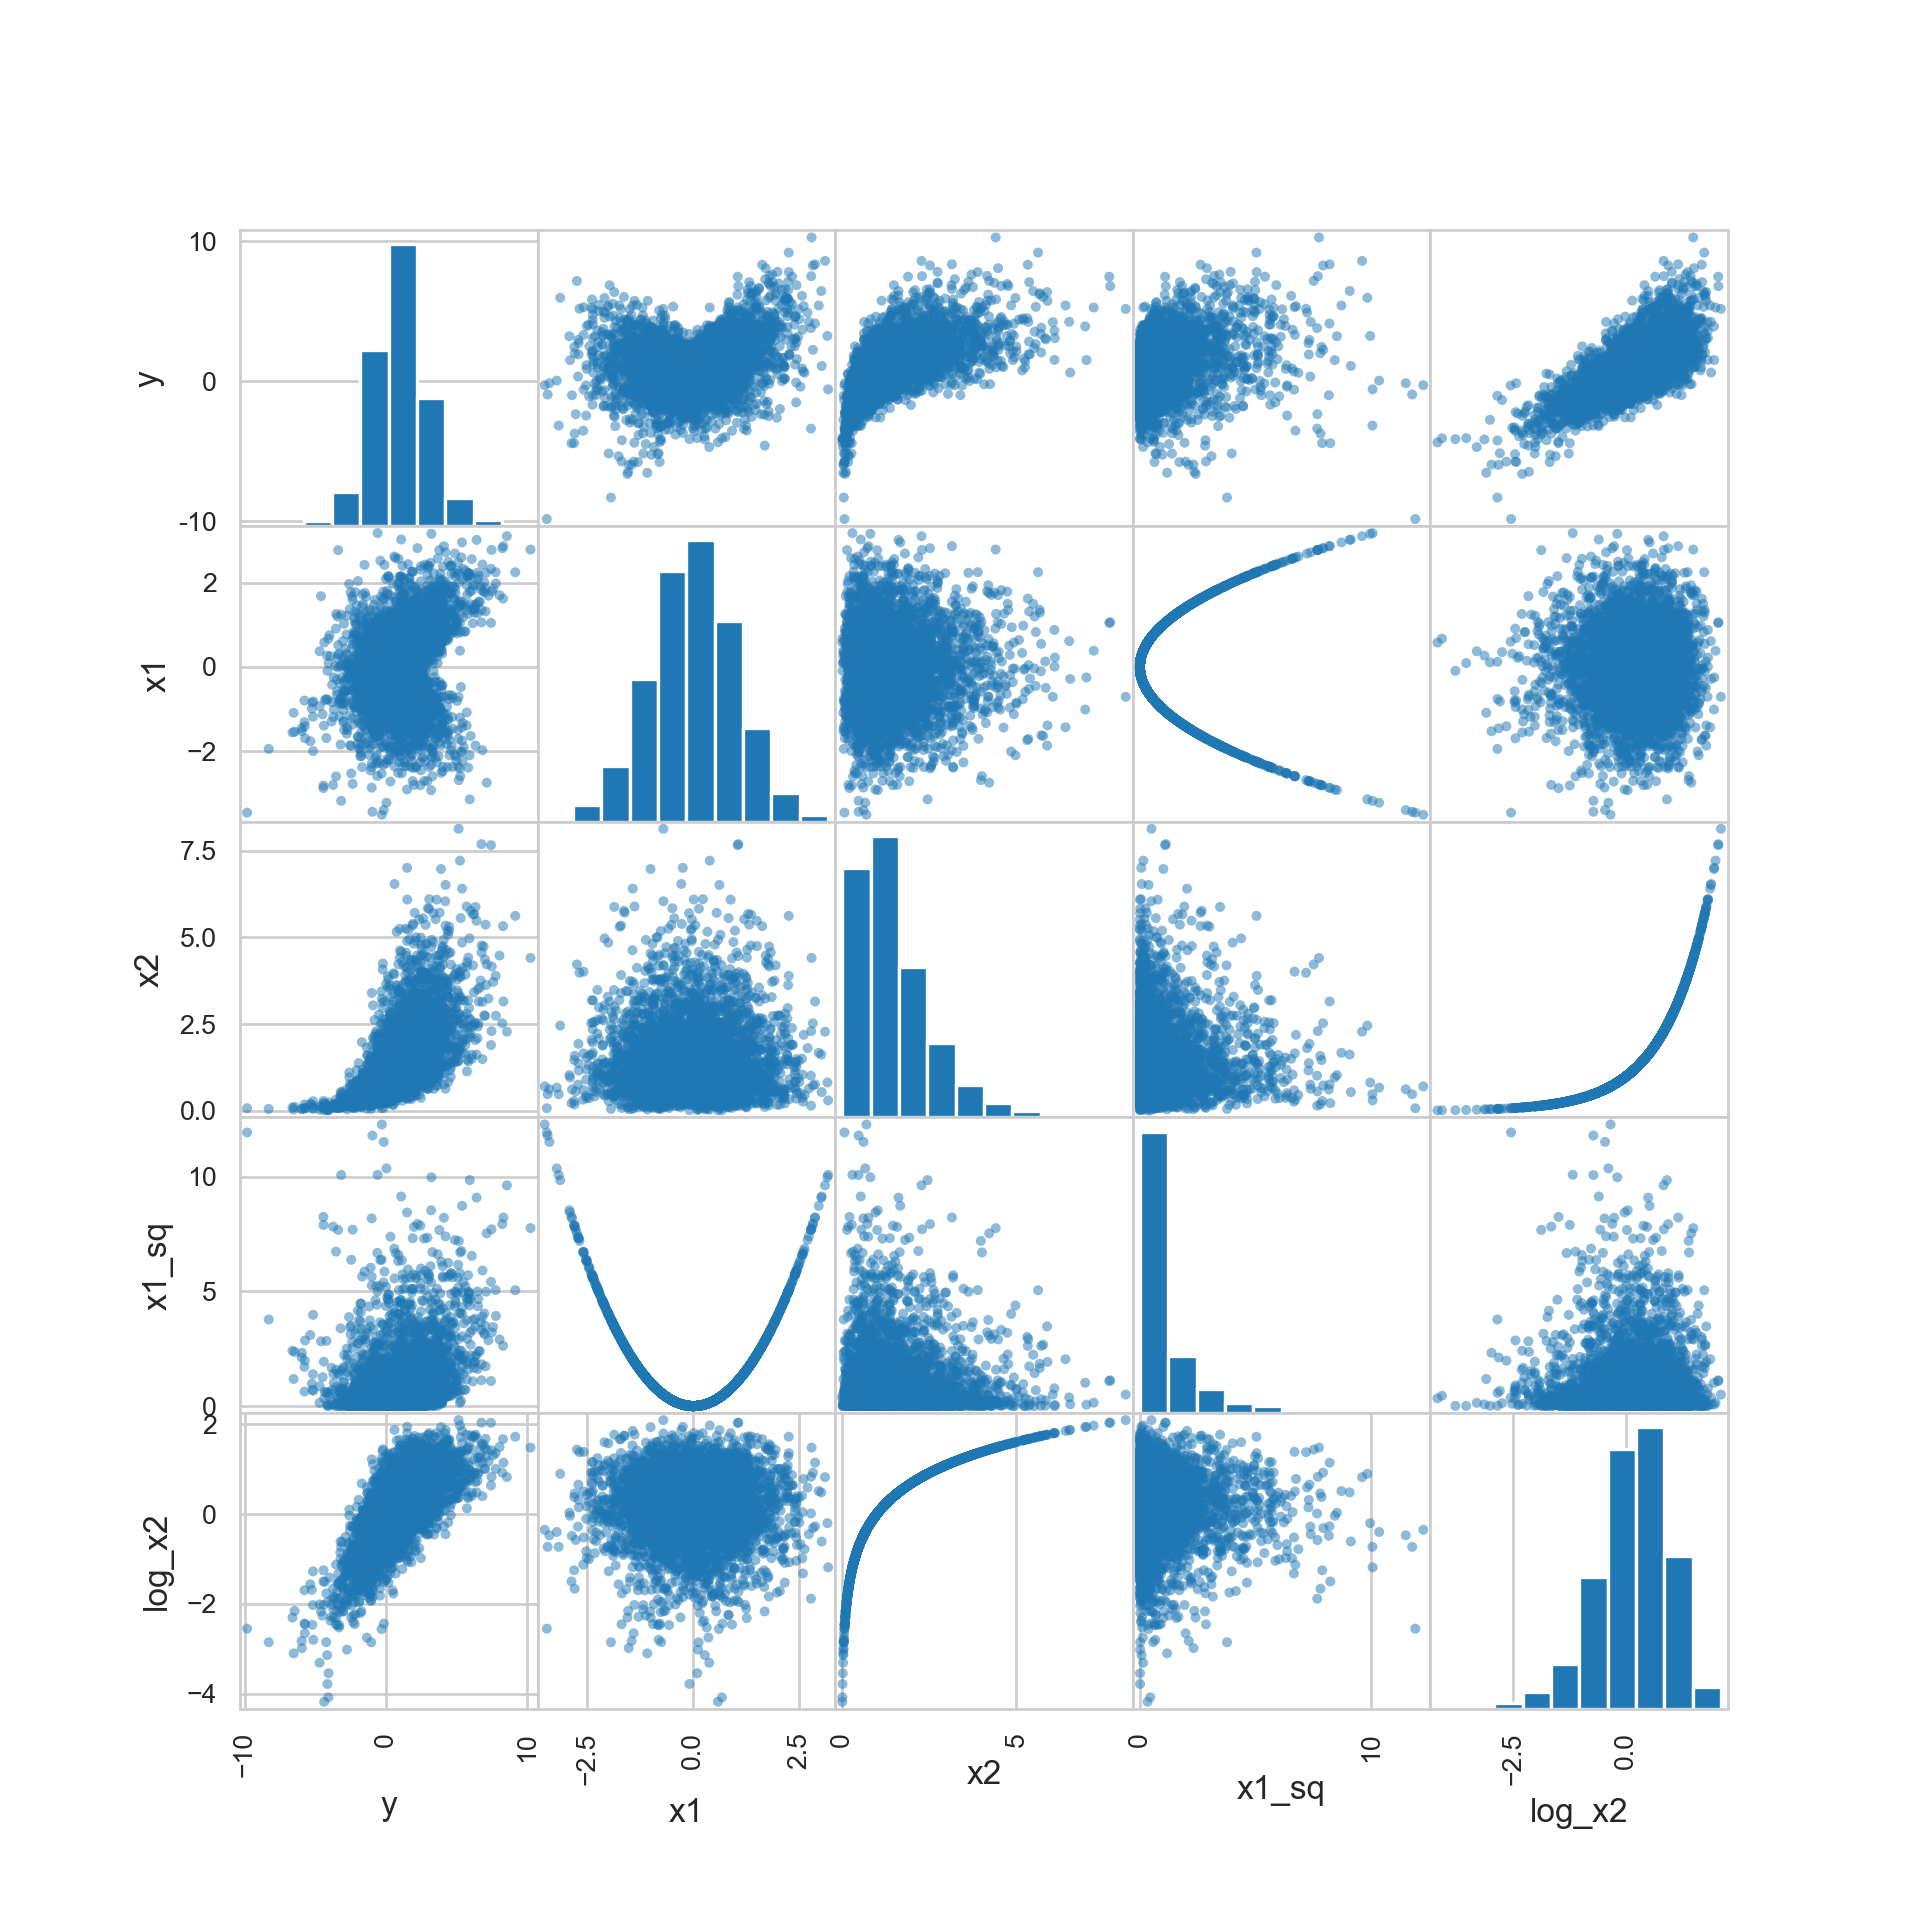

In [133]:
scatter_matrix(df_train, figsize=(8,8))

plt.show()

In [134]:
plt.close()

Now there certainly appears to be a relationship between $x_1$ and $y$ and $x_2$ and $y$. While the relationship between $x_2$ and $y$ might be linear, the relationship between $x_1$ and $y$ is definitely not linear.

One way to address this is to make a polynomial transformation of $x_1$. For instance $x_1^2$.

In [136]:
df_train['x1_sq'] = df_train['x1']**2

<IPython.core.display.Javascript object>


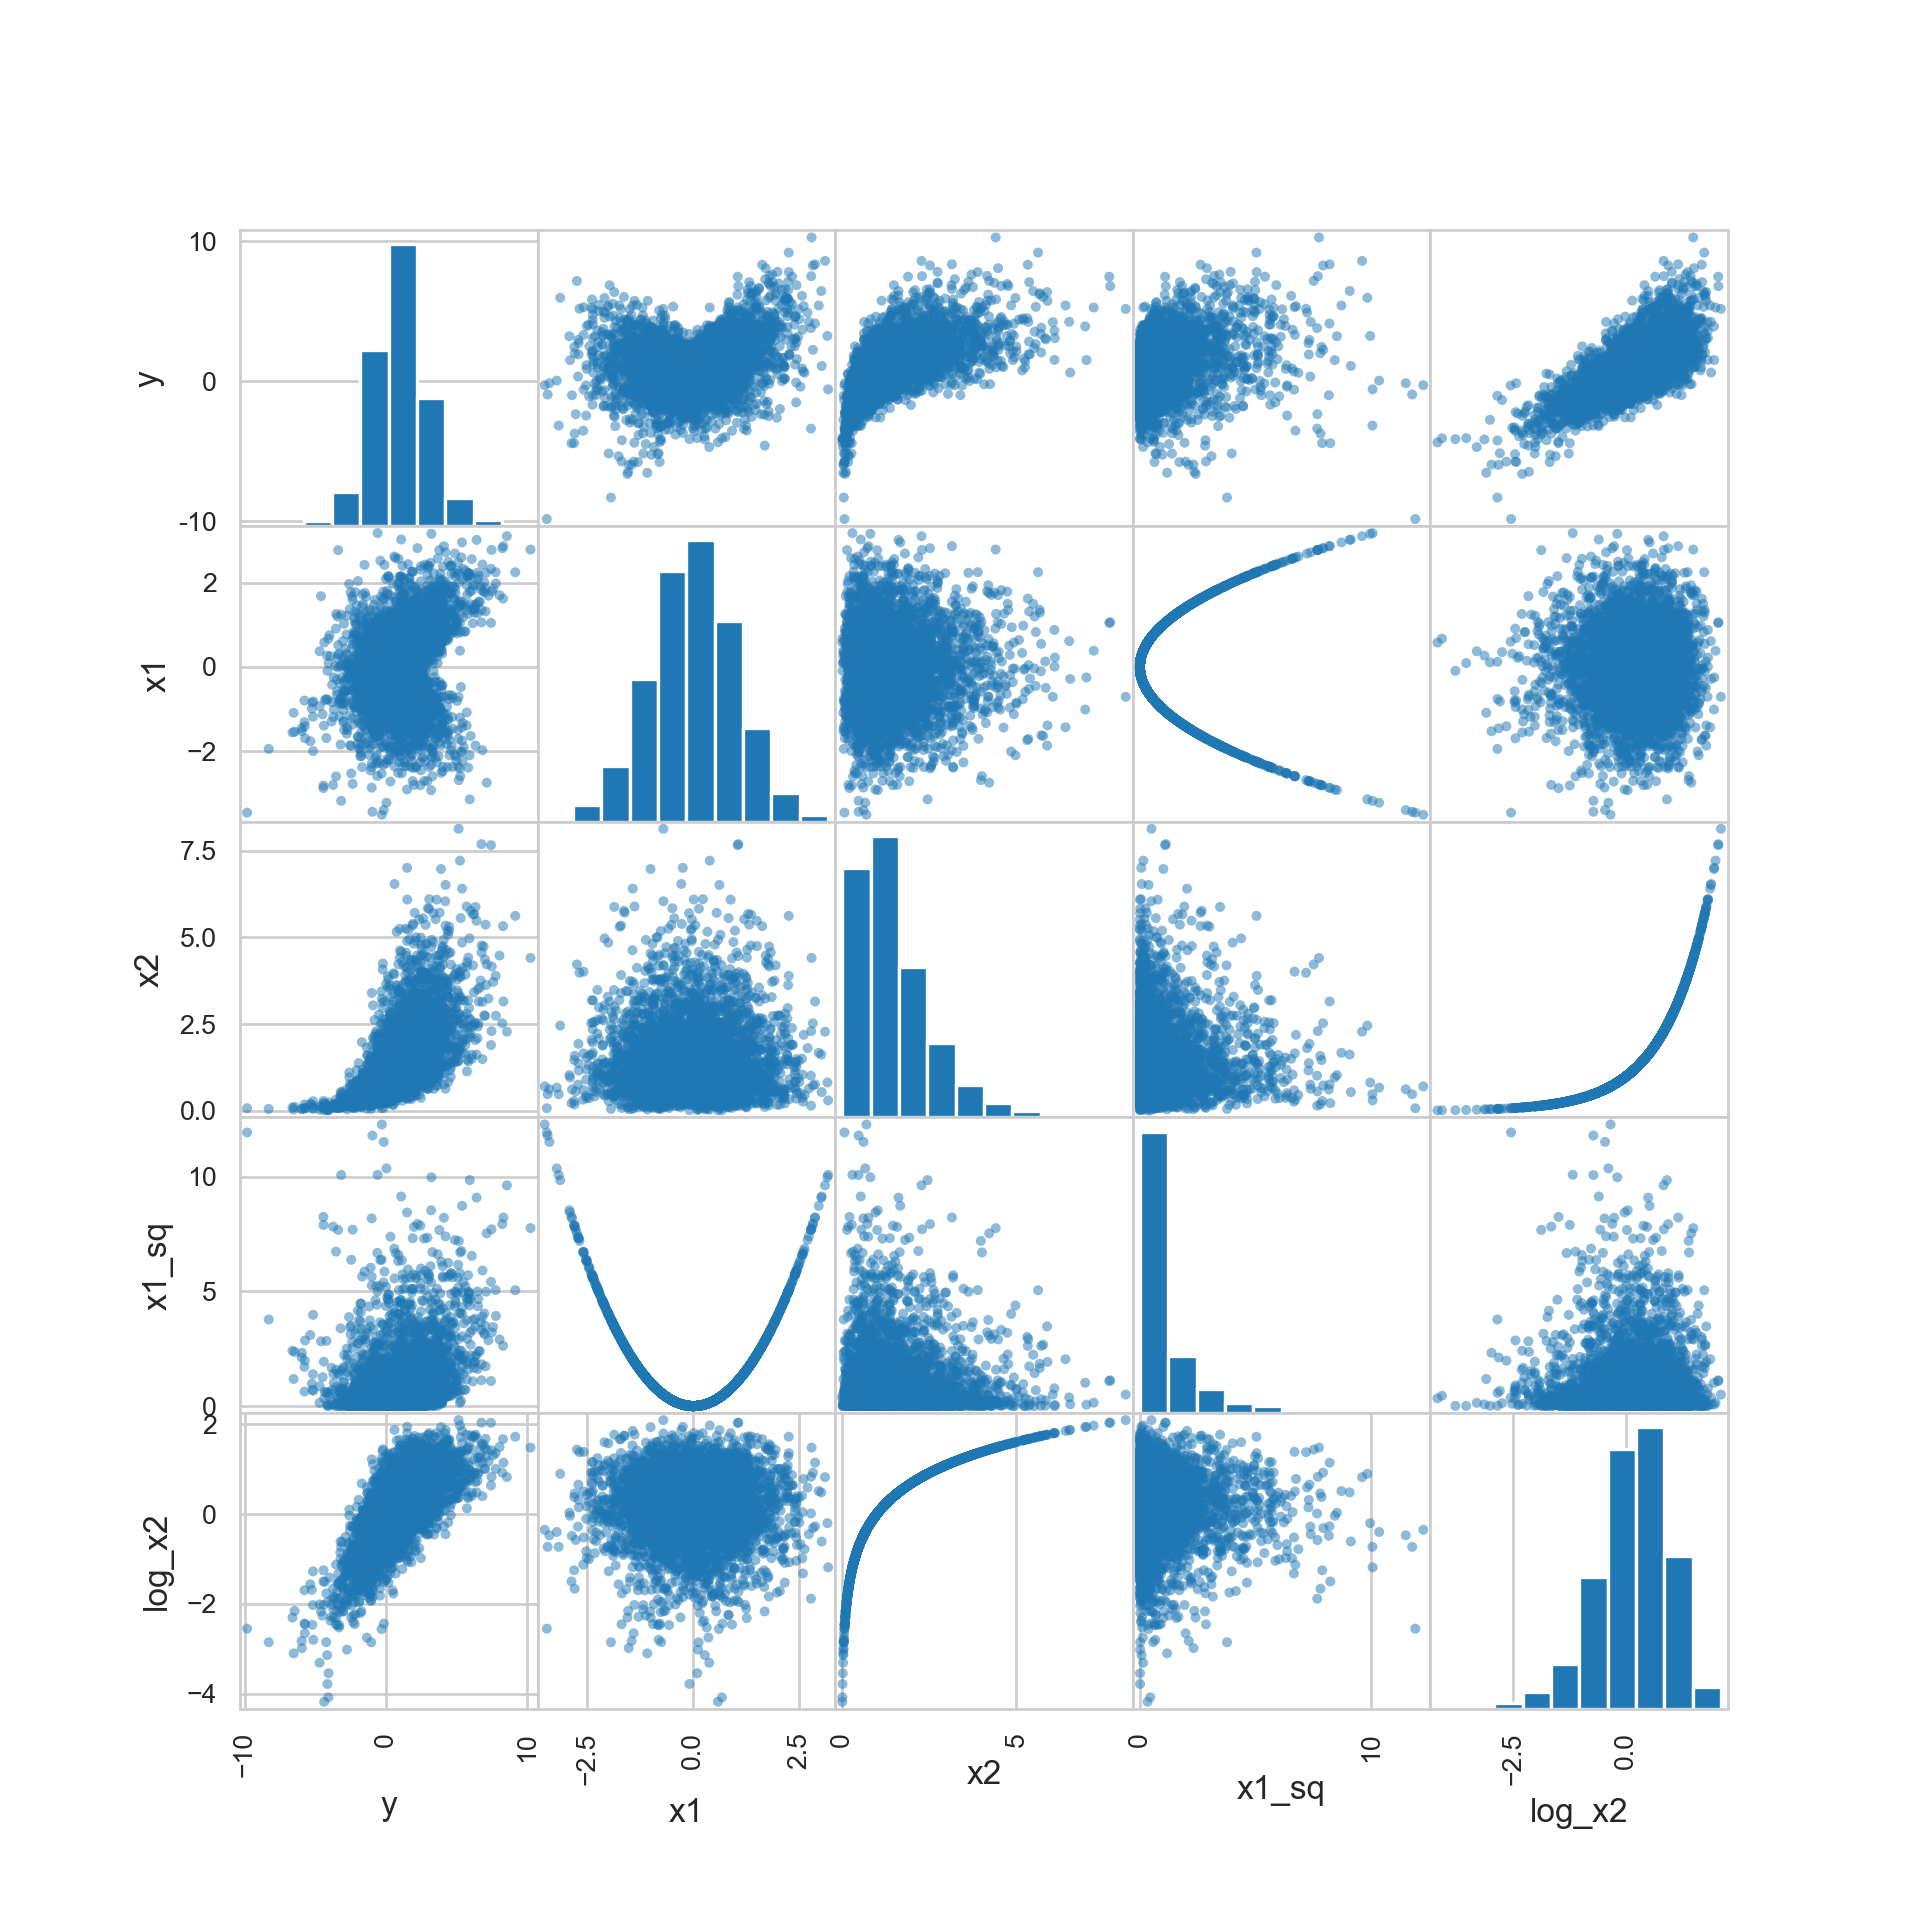

In [137]:
scatter_matrix(df_train, figsize=(8,8))

plt.show()

In [138]:
plt.close()

The relationship between $y$ and $x_1^2$ seems somewhat linear, let's now include it in a model:
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_1^2 + \beta_3 x_2 + \epsilon,
$$
and then we'll fit this model.

In [139]:
reg = LinearRegression(copy_X = True)

reg.fit(df_train[['x1','x1_sq','x2']], df_train['y'])

LinearRegression()

In [140]:
print("beta_0_hat is",np.round(reg.intercept_,5))
print("beta_1_hat is",np.round(reg.coef_[0],5))
print("beta_2_hat is",np.round(reg.coef_[1],5))
print("beta_3_hat is",np.round(reg.coef_[2],5))

beta_0_hat is -1.095
beta_1_hat is 0.52942
beta_2_hat is 0.39165
beta_3_hat is 1.16571


In [141]:
# Let's examine the residual plot
pred = reg.predict(df_train[['x1','x1_sq','x2']])

res = df_train['y'] - pred

<IPython.core.display.Javascript object>


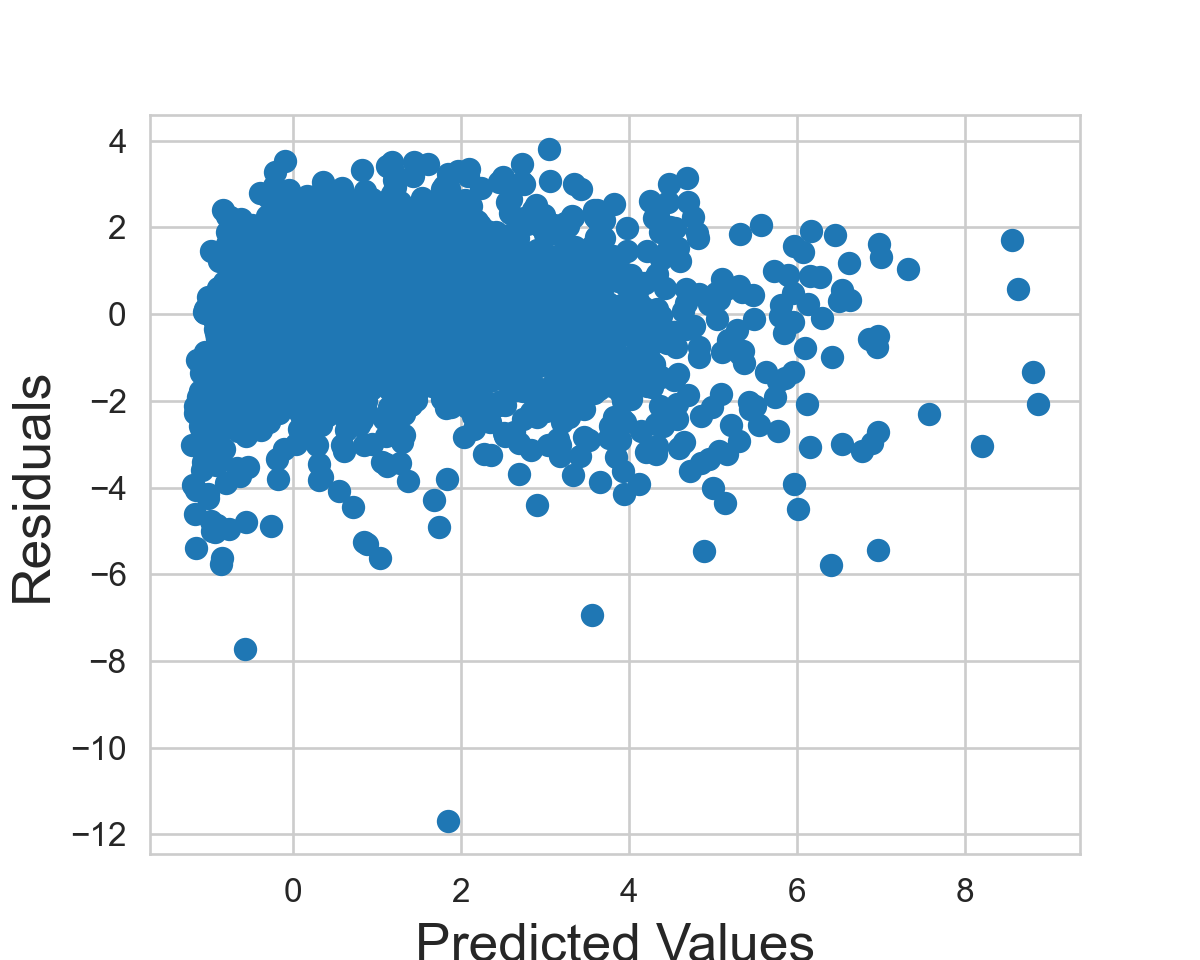

In [142]:
plt.figure(figsize = (5,4))

plt.scatter(pred,res)

plt.xlabel("Predicted Values", fontsize=16)
plt.ylabel("Residuals", fontsize=16)

plt.show()

In [143]:
plt.close()

Definitely not random!

An obviously nonrandom residual plot indicates that there is some signal in the data not being captured by our model. One way to address this is to add an interaction term. Let's try adding in $x_1 x_2$, so our model becomes:
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_1^2 + \beta_3 x_2 + \beta_4 x_1 x_2 + \epsilon
$$

In [144]:
# First add the interaction term to the df
df_train['x1_x2'] = df_train['x1']*df_train['x2']

In [145]:
reg = LinearRegression(copy_X = True)

reg.fit(df_train[['x1','x1_sq','x2','x1_x2']], df_train['y'])

LinearRegression()

In [146]:
print("beta_0_hat is",np.round(reg.intercept_,5))
print("beta_1_hat is",np.round(reg.coef_[0],5))
print("beta_2_hat is",np.round(reg.coef_[1],5))
print("beta_3_hat is",np.round(reg.coef_[2],5))
print("beta_4_hat is",np.round(reg.coef_[3],5))

beta_0_hat is -1.09528
beta_1_hat is 0.56452
beta_2_hat is 0.39211
beta_3_hat is 1.16568
beta_4_hat is -0.02366


In [147]:
# Let's re-examine the residual plot
pred = reg.predict(df_train[['x1','x1_sq','x2','x1_x2']])

res = df_train['y'] - pred

<IPython.core.display.Javascript object>


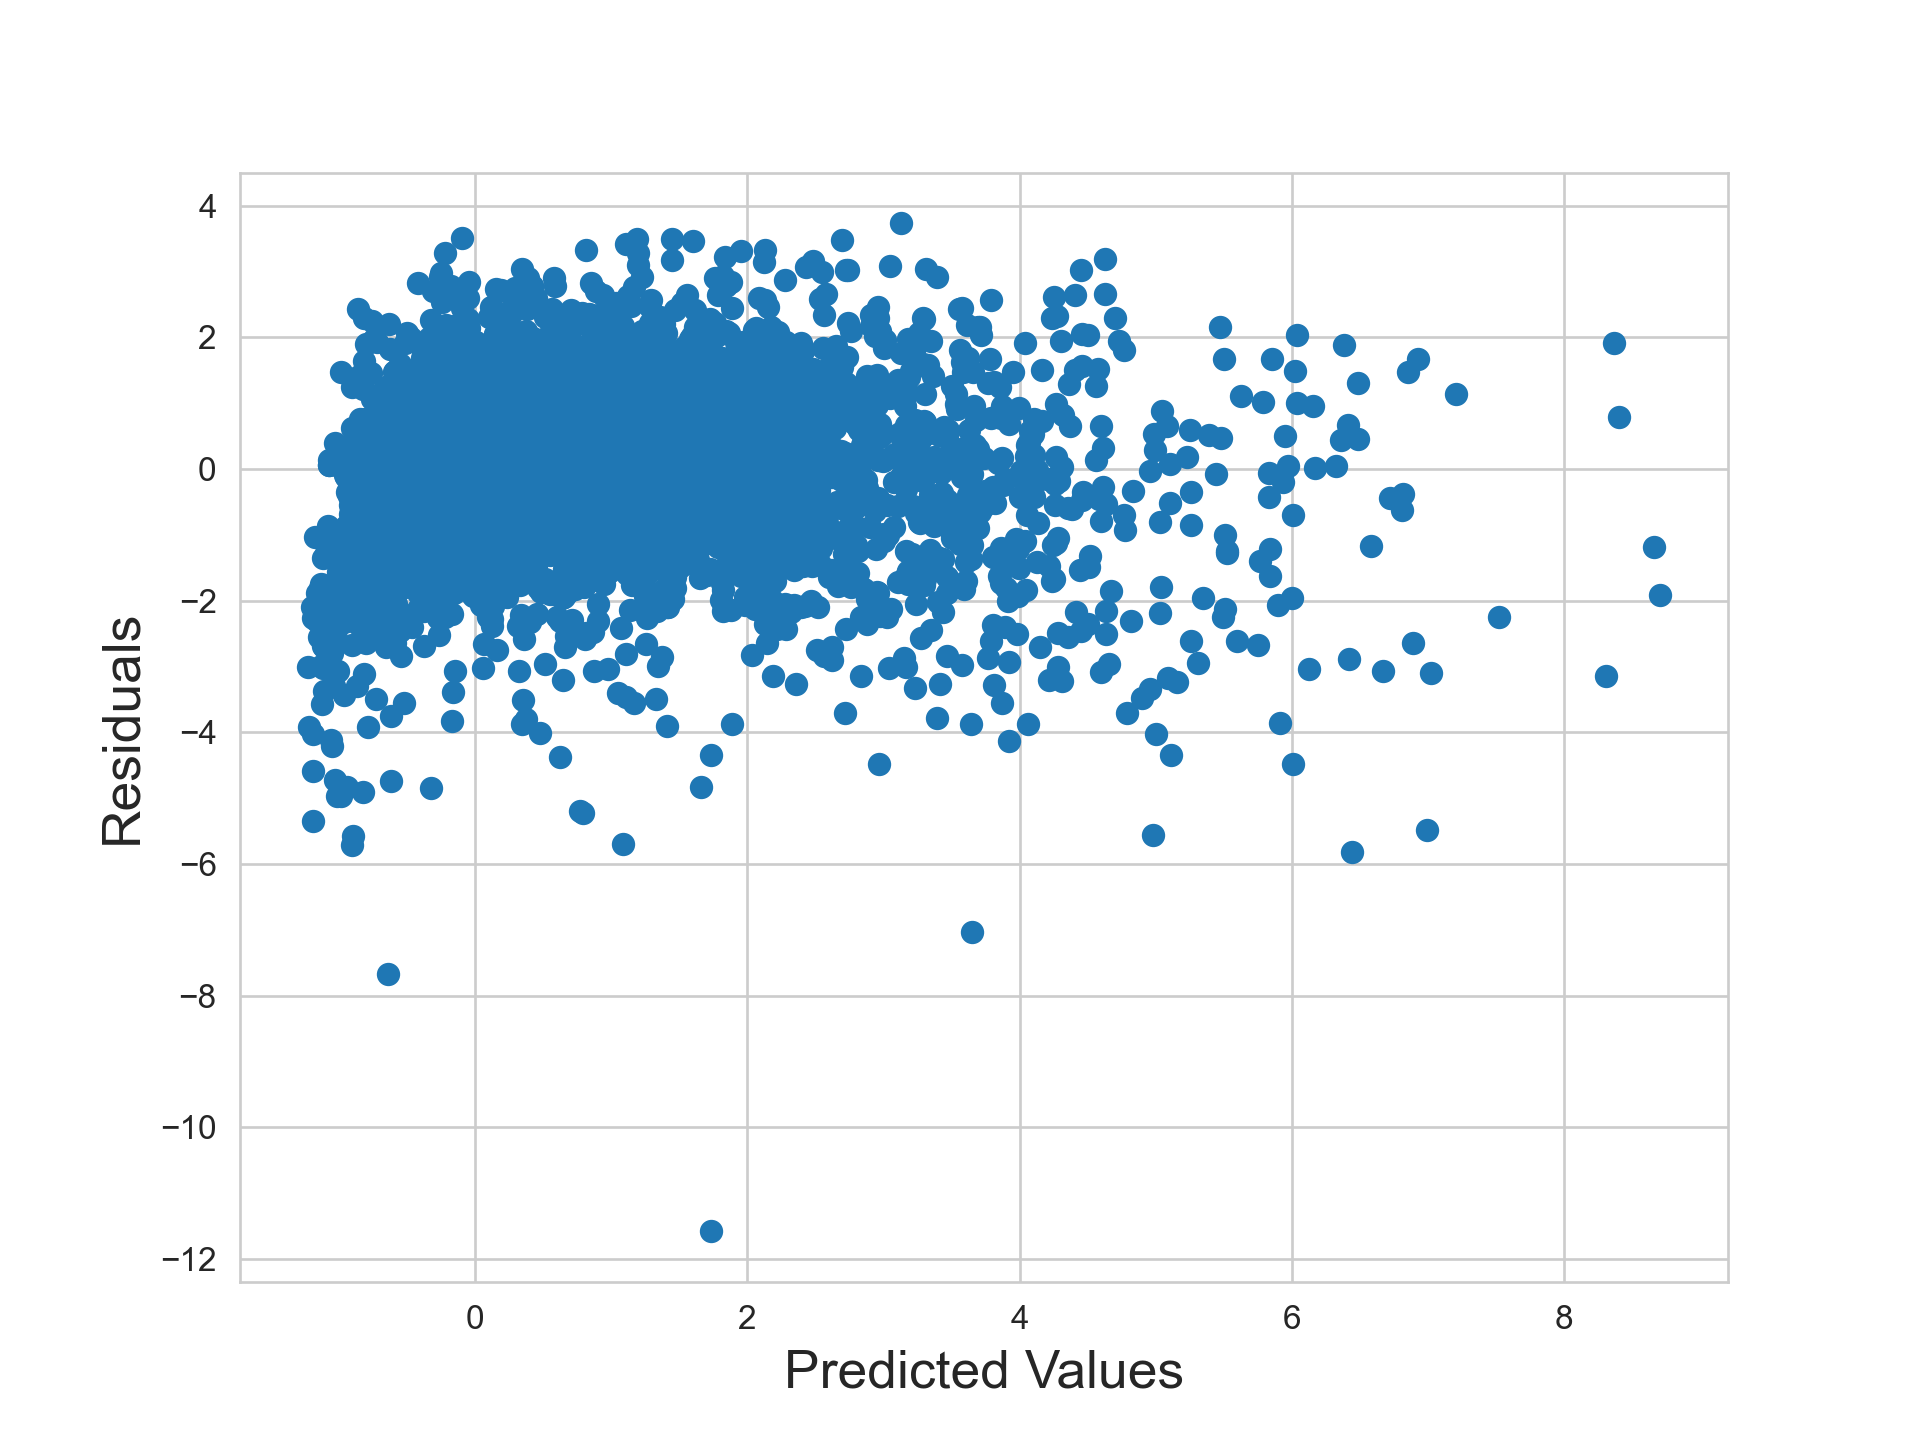

In [148]:
plt.figure(figsize = (8,6))

plt.scatter(pred, res)

plt.xlabel("Predicted Values", fontsize=16)
plt.ylabel("Residuals", fontsize=16)

plt.show()

In [149]:
plt.close()

So much better!

#### Which is the Best Model?

While this certainly seems like the best model, we'll discuss how we can compare the two models in a more robust way in a later notebook.

#### Do I Need to Include it?

If you notice the coefficient on $x_1$ is close to $0$ in the interaction term model. It may be tempting to remove this feature from the model especially if the true relationship was:
$$
y = 2 + x_1^2 - 10 x_2 + x_1 x_2.
$$
However, there is no way for you to know ahead of time what the true relationship is between the target and the features, if there was there'd be no need for regression. 

To further illustrate this point, imagine the true relationship was such that:
$$
y \propto x_1^2,
$$
if we do not include $x_1$ in our model we are limiting ourselves to parabolas of the form
$$
\beta_0 + \beta_1 x_1^2,
$$
which leaves out a number of possible parabolas.

It is important to remember that anytime you make a model that includes a polynomial transformation you need to include all of the lesser powers as well. So with $x_1^2$ as the highest power you'd need to include $x_1$, with $x_1^3$ as the highest power you'd need to include $x_1^2$ and $x_1$, and so on for $x_1^n$.

This also holds for interaction terms. If you include $x_1 x_2$ you need to include both $x_1$ and $x_2$ as predictors as well.


### You Code

The data labeled `df` below came from a job interview problem set. In the homework you'll have to build the best predictive model you can on the data. For now examine the relationship between `y` and `x1`. Build a model to predict `y` using `x1`.

In [150]:
## Load the data
df = pd.read_csv("PredictiveModelingAssessmentData.csv")

## Make a train test split
df_train = df.copy().sample(frac = .75, random_state = 440)
df_test = df.copy().drop(df_train.index)
df_train.head()

y        x1        x2
1208  0.275934  0.042981  1.477678
879  -0.642955 -1.366220  1.182469
2569  1.222617 -1.309346  1.556943
1959 -1.316349 -0.298128  1.594010
8     0.900841  0.859962  1.112171

<IPython.core.display.Javascript object>


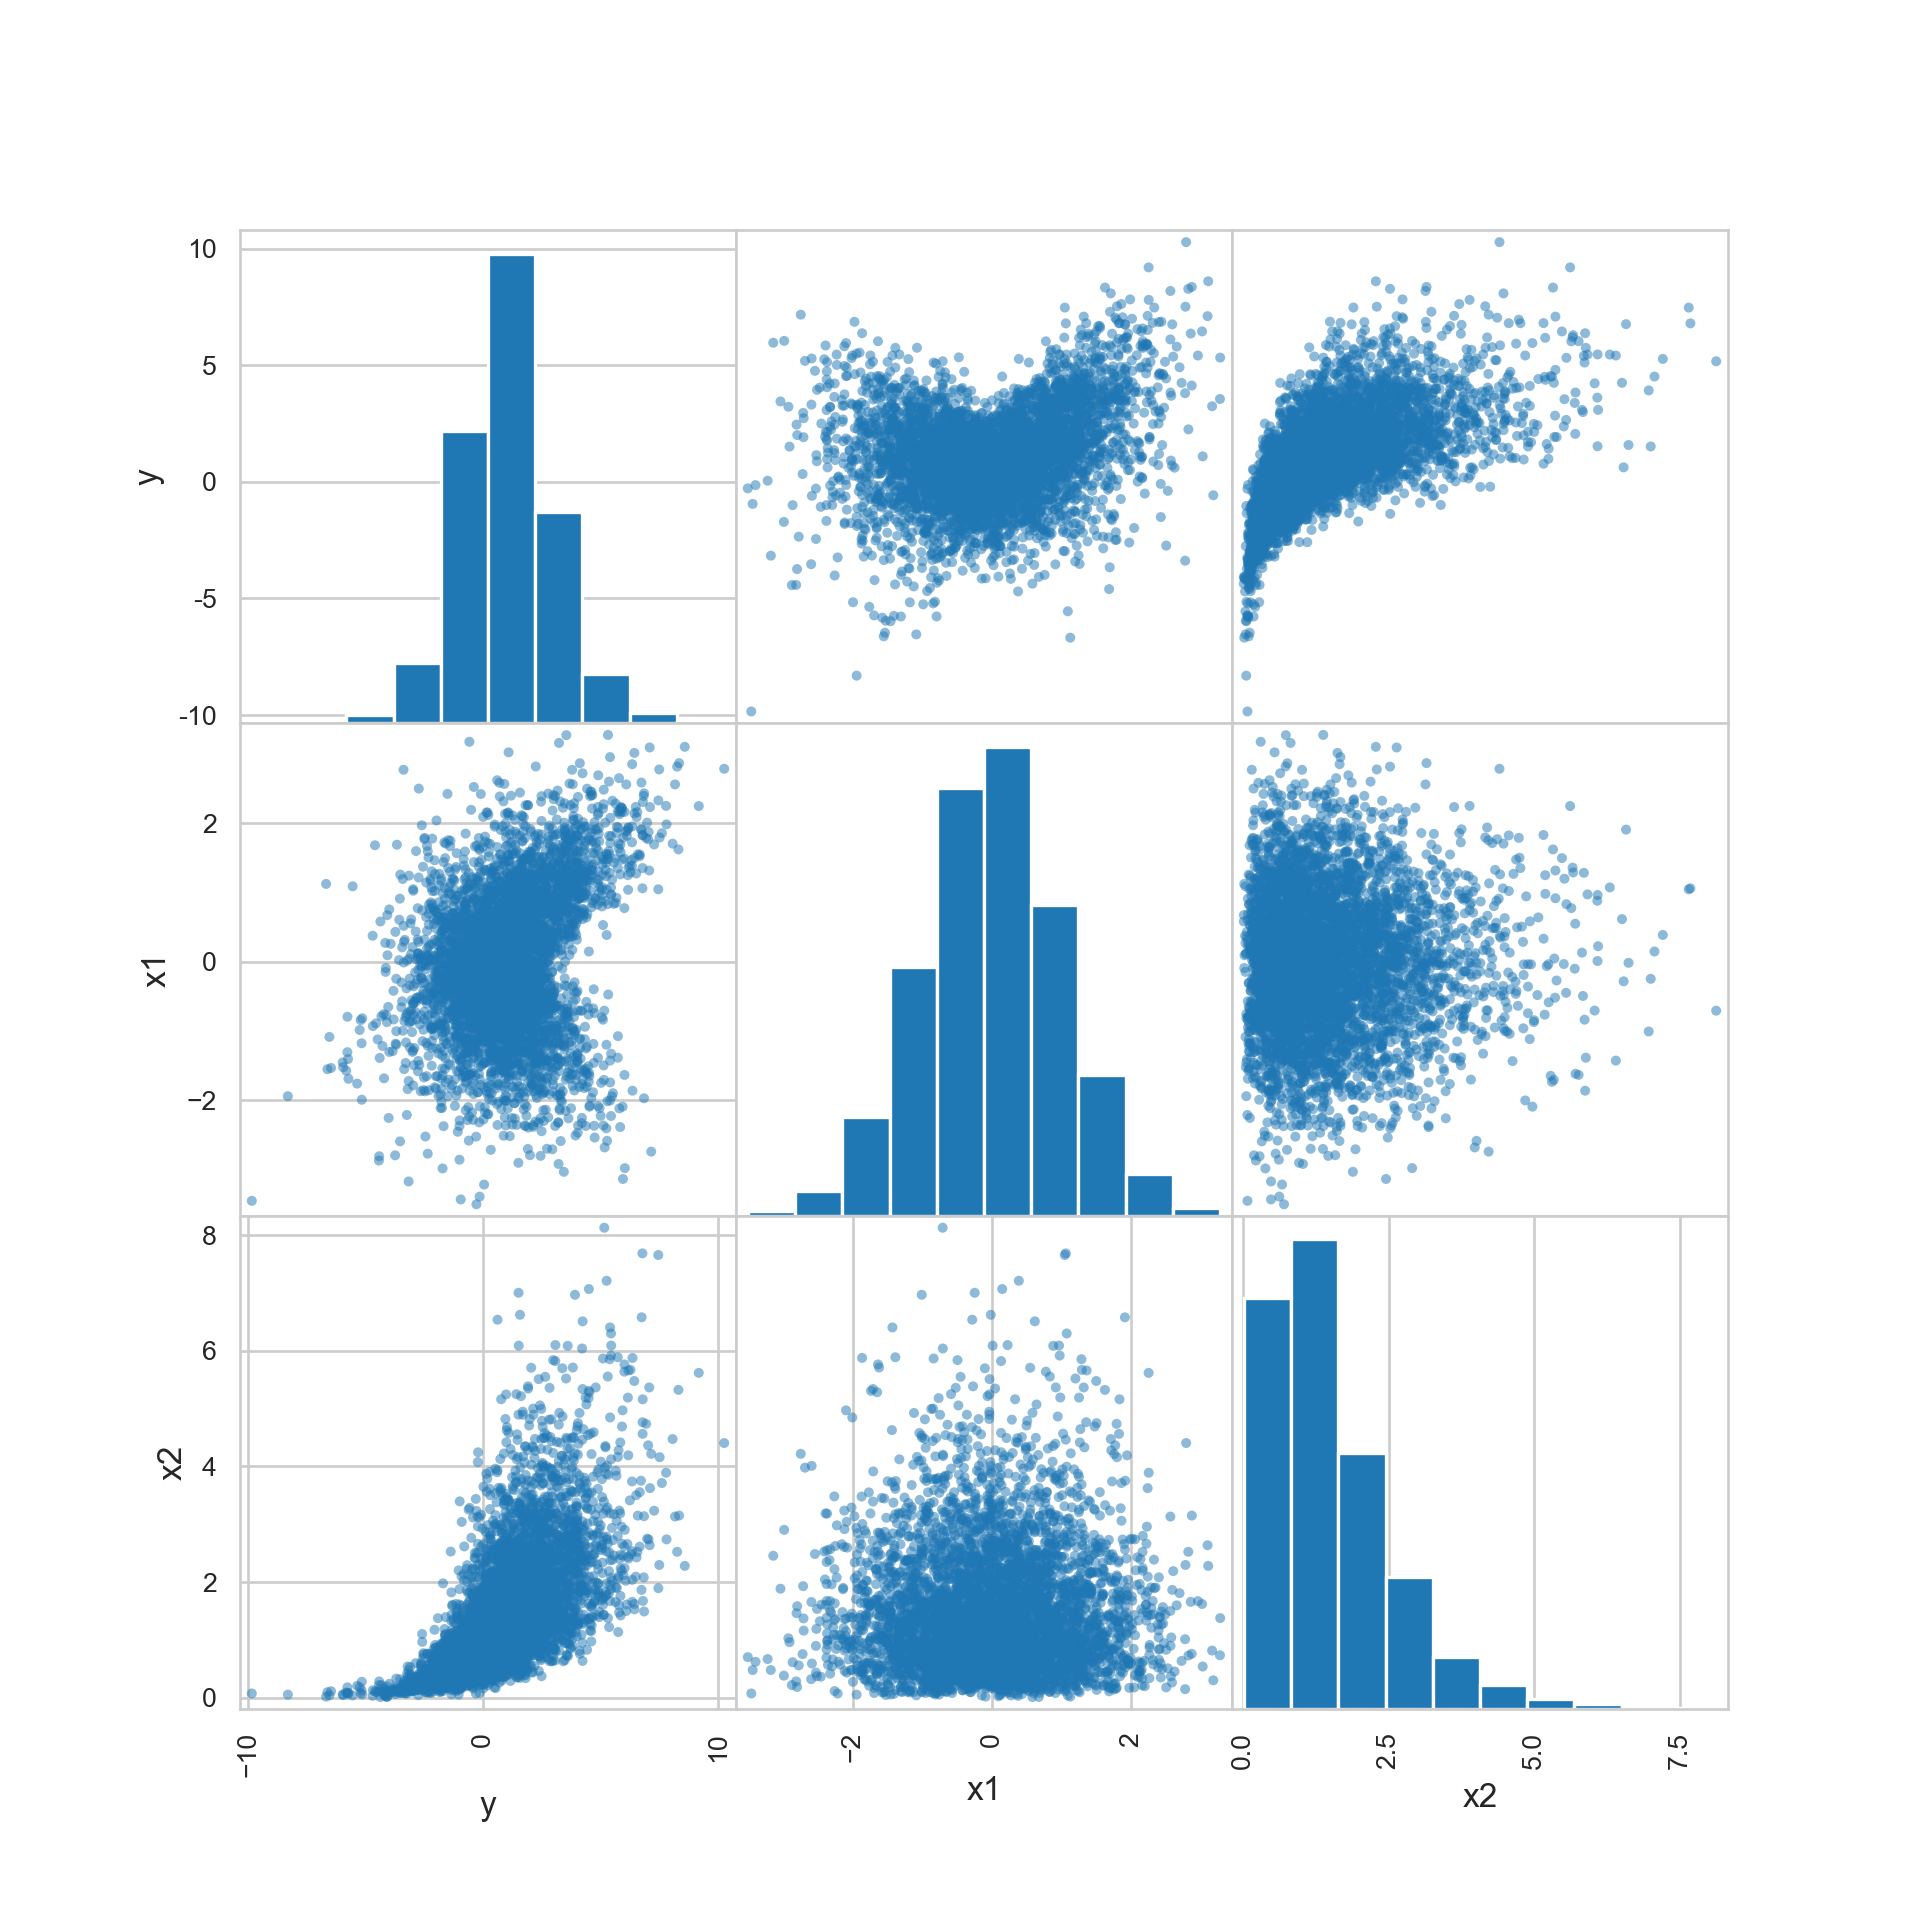

In [153]:
## Examine the scatter matrix here

## Sample Answer
scatter_matrix(df, figsize=(8,8))

plt.show()

In [154]:
plt.close()

In [78]:
## Get the appropriately transformed column

## Sample Solution
df_train['x1_sq'] = df_train['x1']**2

In [79]:
## Fit the Regression here

## Sample Answer
reg = LinearRegression(copy_X = True)

reg.fit(df_train[['x1','x1_sq']],df_train['y'])

LinearRegression()

## Other Popular Transformations

We can add in more than just polynomials. There are other popular transformations including $\log$s, roots, $\sin$, $\cos$, $\tan$, exponentials, and more.

We'll work through an example returning to our `Advertising` data then you'll make a model for the interview data.

<IPython.core.display.Javascript object>


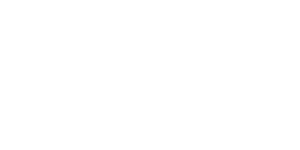

In [80]:
scatter_matrix(ads_train, figsize = (8,8), alpha = 1)

plt.show()

In [81]:
plt.close()

<IPython.core.display.Javascript object>


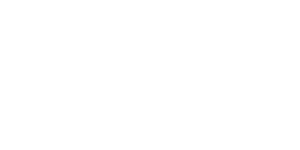

In [82]:
plt.figure(figsize = (5,5))

plt.scatter(np.sqrt(ads_train.TV),ads_train.sales)

plt.xlabel("$\sqrt{TV}$", fontsize = 16)
plt.ylabel("sales", fontsize = 16)

plt.show()

In [83]:
plt.close()

This looks much more linear. Let's replace `TV` in our model from Notebook 3 with root `TV`.
$$
\text{sales} = \beta_0 + \beta_1 \sqrt{\text{TV}} + \beta_2 \text{radio} + \epsilon
$$

In [84]:
# Add in root tv to the df
ads_train['sqrt_TV'] = np.sqrt(ads_train.TV)

In [85]:
# Make the model object
reg = LinearRegression(copy_X = True)

In [86]:
# Fit the data
reg.fit(ads_train[['sqrt_TV','radio']],ads_train['sales'])

LinearRegression()

In [87]:
print("beta_0_hat is",np.round(reg.intercept_,5))
print("beta_1_hat is",np.round(reg.coef_[0],5))
print("beta_2_hat is",np.round(reg.coef_[1],5))

beta_0_hat is -1.96191
beta_1_hat is 1.00536
beta_2_hat is 0.19705


In [88]:
# Look at the residual plot
pred = reg.predict(ads_train[['sqrt_TV','radio']])

res = ads_train['sales'] - pred

<IPython.core.display.Javascript object>


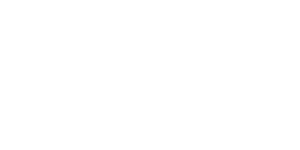

In [89]:
plt.figure(figsize = (8,6))

plt.scatter(pred,res)

plt.xlabel("Predicted Values", fontsize=16)
plt.ylabel("Residuals", fontsize=16)

plt.show()

In [90]:
plt.close()

Again not random. Let's add in the interaction term.

In [91]:
ads_train['sqrtTV_radio'] = ads_train['sqrt_TV'] * ads_train['radio']

In [92]:
## Make the model object
reg = LinearRegression(copy_X = True)

In [93]:
## Fit the data
reg.fit(ads_train[['sqrt_TV','radio','sqrtTV_radio']],ads_train['sales'])

## We'll want to look at these later
print(reg.coef_)

[ 0.44969371 -0.04683335  0.02124826]


In [94]:
## Let's re-examine the residual plot
pred = reg.predict(ads_train[['sqrt_TV','radio','sqrtTV_radio']])

res = ads_train['sales'] - pred

<IPython.core.display.Javascript object>


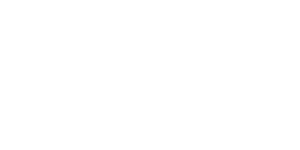

In [95]:
plt.figure(figsize = (5,4))

plt.scatter(pred,res)

plt.xlabel("Predicted Values", fontsize=16)
plt.ylabel("Residuals", fontsize=16)

plt.show()

In [96]:
plt.close()

### You Code

Return to the `PredictiveModelingAssessmentData.csv` data set. Does it appear that $y$ and $x_2$ have a linear relationship?

Try playing around with different non-linear transformations of $x_2$ (note don't use polynomials).

<IPython.core.display.Javascript object>


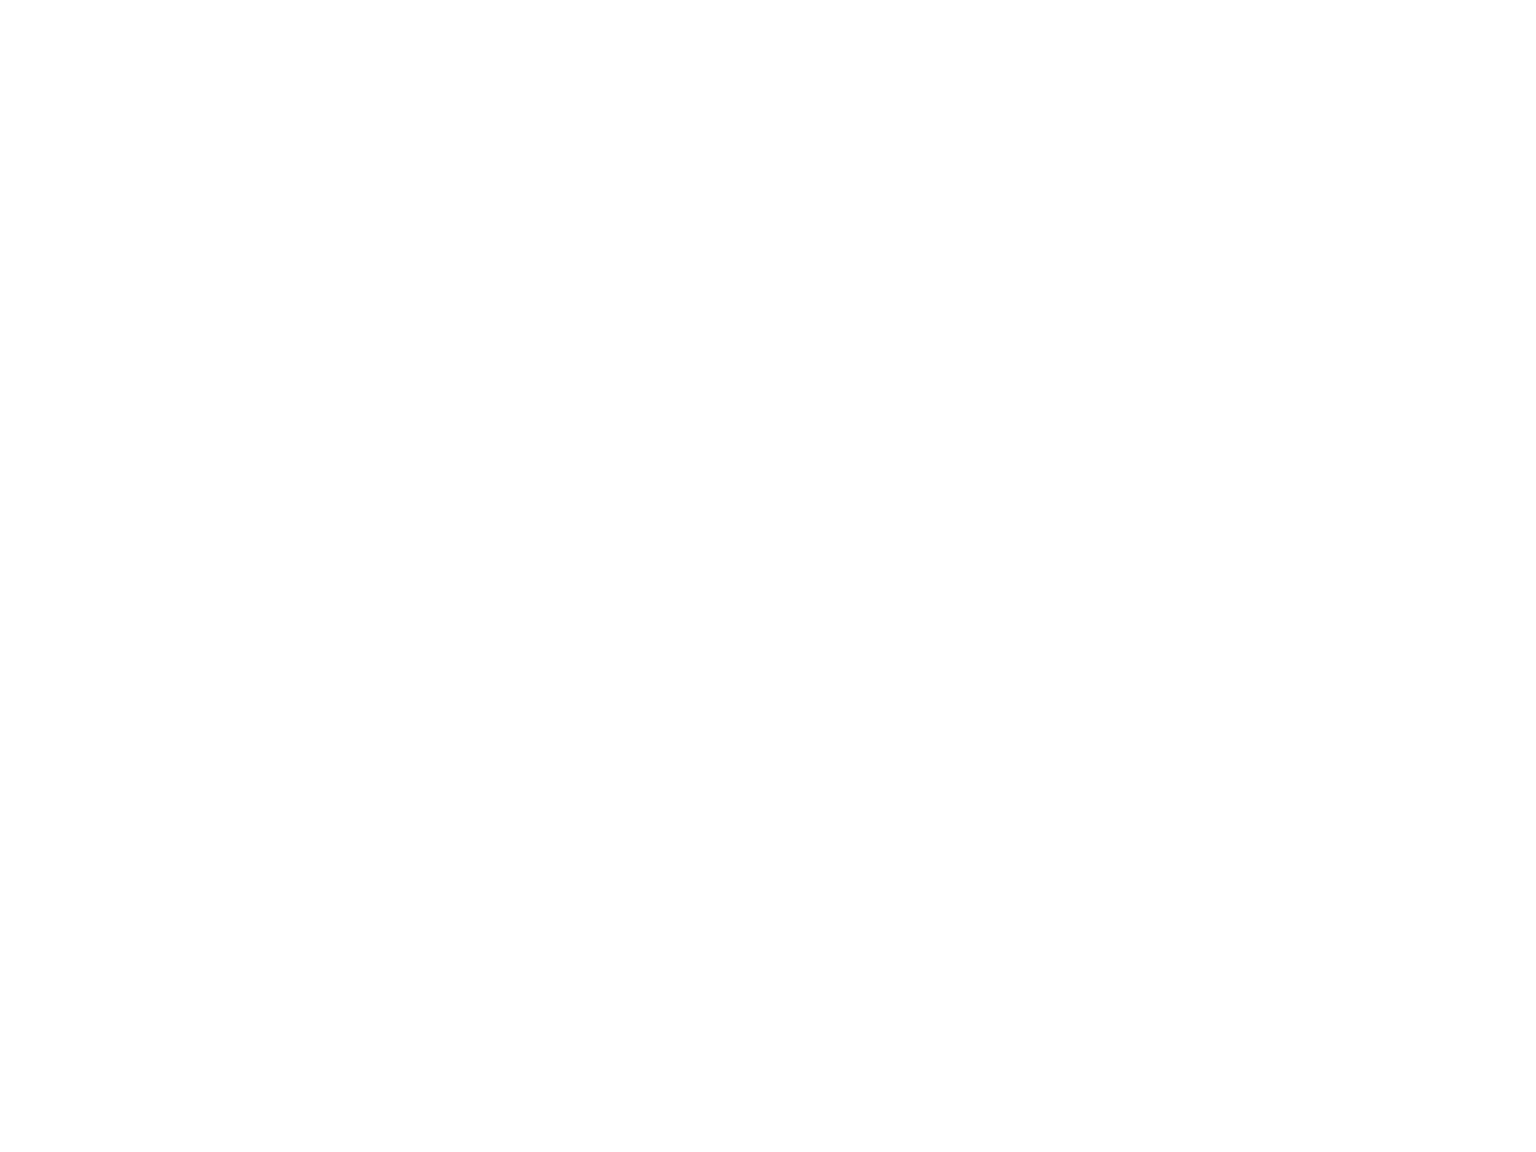

In [97]:
## You code here

## Sample answer

df_train['log_x2'] = np.log(df_train['x2'])


scatter_matrix(df_train)

plt.show()

In [98]:
plt.close()

That's it for this notebook in the next notebook we'll discuss model selection for predictive models.

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2021.

Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)